## Explore Stim & Violation Interactions

**Goal:** assess the variance of the prev_violation regressor for each animal and simulate choice given solved weights 

Specifics:


[X] plot histogram of prev_violation regressor across all trials 

* [X] assess if there are stage differences- NO

* [X] determine if across animal differences- YES

* [X] determine quartiles? or some metric of segregation

[X] perform EDA on violation history / metrics 

[X] explore animal psychometrics & make plots

[X] fit a filter_prev_violation model to all the data for each animal

[X] manipulate weights to be binary (L-R) for sa and sb terms

* [X] visualize to ensure similarities to Akrami

[X] generate data from weights given simulated sb-sa values 

* [X] determine viable range of x given data 

* [X] fit sigmoid to simulated data

* [X] update plots
 
[X] repeat with prev violation filter on (1)

[X] repeat with prev violation filter at animal's median value

[X] move into psychometrics.py


In [28]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pathlib
import sys
[
    sys.path.append(str(folder))
    for folder in pathlib.Path("../src/").iterdir()
    if folder.is_dir()
]
from violations_eda import *
from fitting_utils import create_violation_interaction_pairs, get_taus_df
from get_rat_data import get_rat_viol_data
from experiment_sigma_sweep import ExperimentSigmaSweep
from multiclass_logistic_regression import MultiClassLogisticRegression
from model_visualizer import ModelVisualizer
from design_matrix_generator import DesignMatrixGenerator, DesignMatrixGeneratorInteractions
from psychometrics import *
sns.set_context("talk")
%load_ext autoreload
%autoreload 2

results_path = "/Users/jessbreda/Desktop/github/animal-learning/data/results/"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Create Prev Violation Filtered Regressor for each Animal & Plot Histograms


In [29]:
prev_violation_df = generate_design_mat_with_filter_viol()
prev_violation_df.head()

returning viol data for W051
returning viol data for W060
returning viol data for W061
returning viol data for W062
returning viol data for W065
returning viol data for W066
returning viol data for W068
returning viol data for W072
returning viol data for W073
returning viol data for W074
returning viol data for W075
returning viol data for W078
returning viol data for W080
returning viol data for W081
returning viol data for W082
returning viol data for W083
returning viol data for W088
returning viol data for W089
returning viol data for W094


bias  session       s_a       s_b  prev_sound_avg  prev_correct   
0     1       31 -0.669122  0.137400             0.0           0.0  \
1     1       31 -0.669122 -1.489019            -0.0          -0.0   
2     1       31 -0.669122  0.137400            -0.0           0.0   
3     1       31  0.106330 -0.675809            -0.0          -0.0   
4     1       31  0.881783  0.137400            -0.0           0.0   

   prev_choice  stage  prev_violation_exp animal_id  prev_violation_tau  
0          0.0      3            0.000000      W051                   6  
1          0.0      3            0.154560      W051                   6  
2          0.0      3            0.285392      W051                   6  
3          0.0      3            0.396139      W051                   6  
4          0.0      3            0.489884      W051                   6

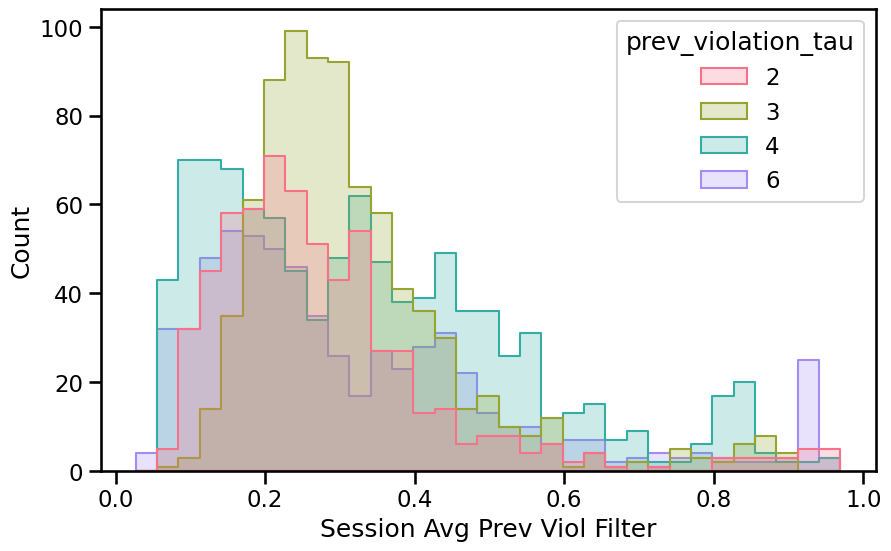

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.histplot(
    data=prev_violation_df.groupby(["animal_id", "session", "prev_violation_tau"])
    .prev_violation_exp.mean()
    .reset_index(),
    x="prev_violation_exp",
    hue="prev_violation_tau",
    palette=sns.color_palette("husl", 4),
    element="step",
    ax=ax,
)

_ = ax.set(xlabel="Session Avg Prev Viol Filter")

The plot above is a histogram of the average filter value for each animal in each session, colored by the filter tau. It can be seen that the larger prev_violation_taus have some what of a bi-modal distribution. Whereas the smaller (2,3) have a smoother right skew. 

For the animals that have tau = 6 as the best fitting filter, I wonder if this is because they have multiple sessions where they only violate (and the filter would be close to 1 the whole time). Or, if this is due to them violating in clumps. 

> **IDEA** plot number of sessions with high violation rate. Also plot average number of consecutive violations for animal and relate back to this average filter plot.


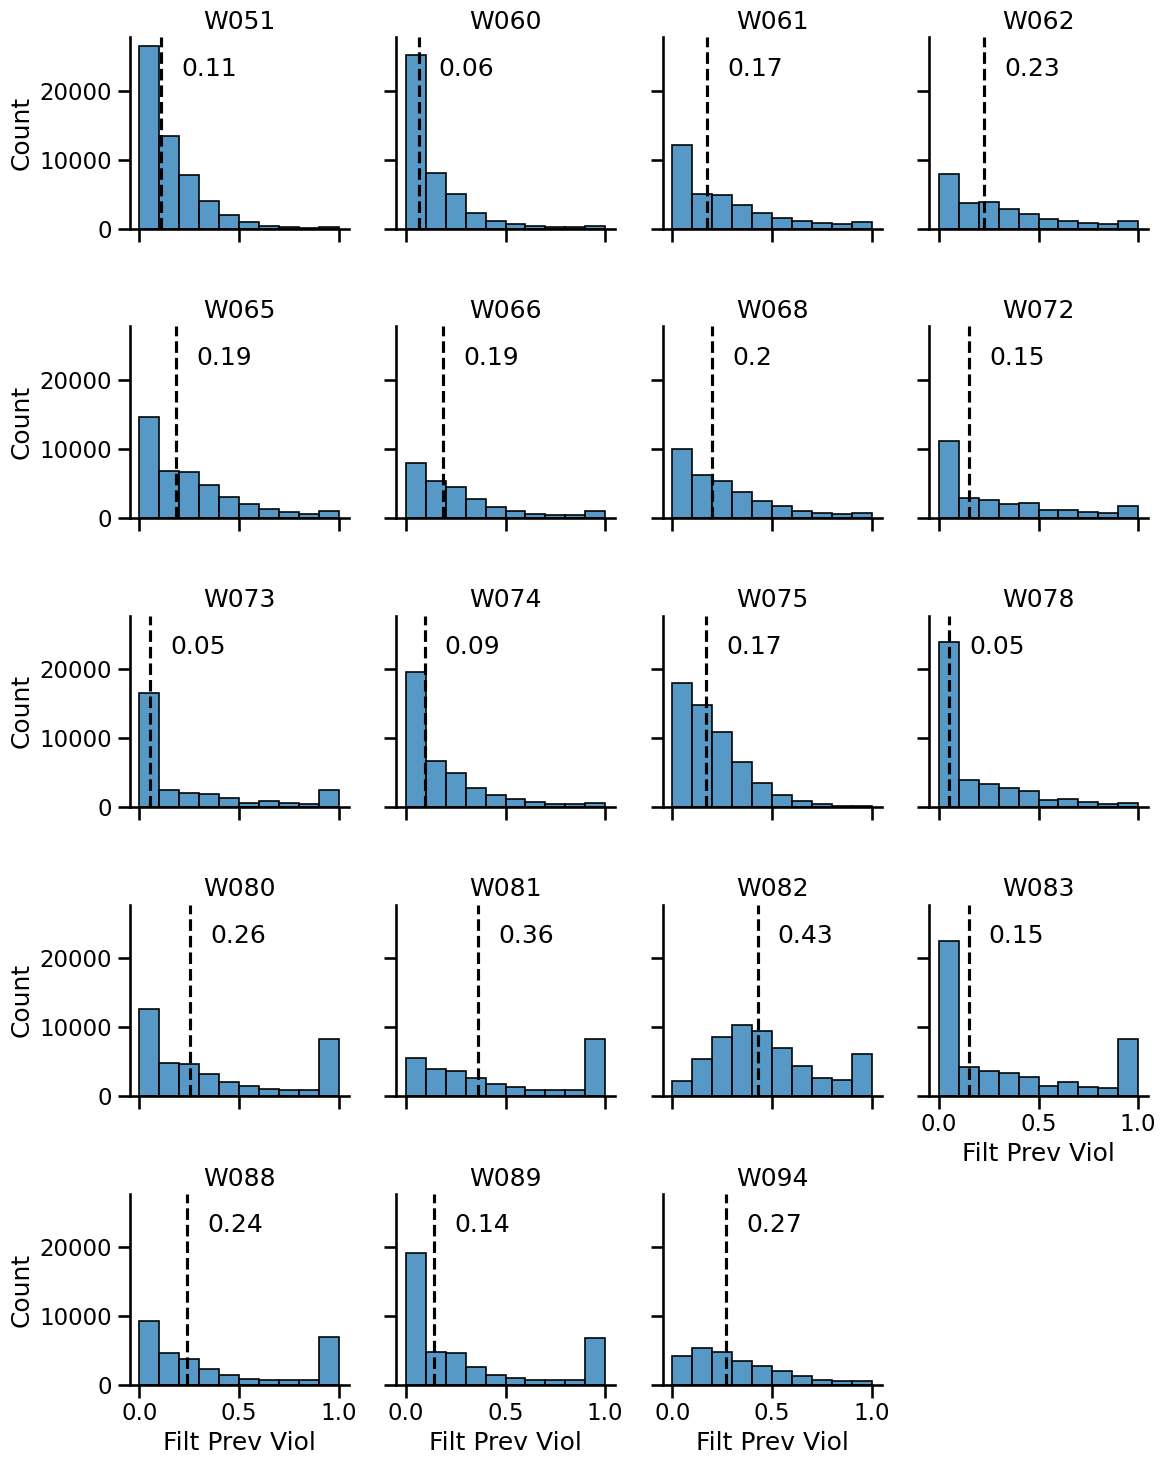

In [ ]:
g = plot_histogram_facet_grid(prev_violation_df, "prev_violation_exp", binwidth=0.1)

g.map_dataframe(plot_prev_viol_median)
g.set_axis_labels("Filt Prev Viol", "Count")
g.set_titles("{col_name}")

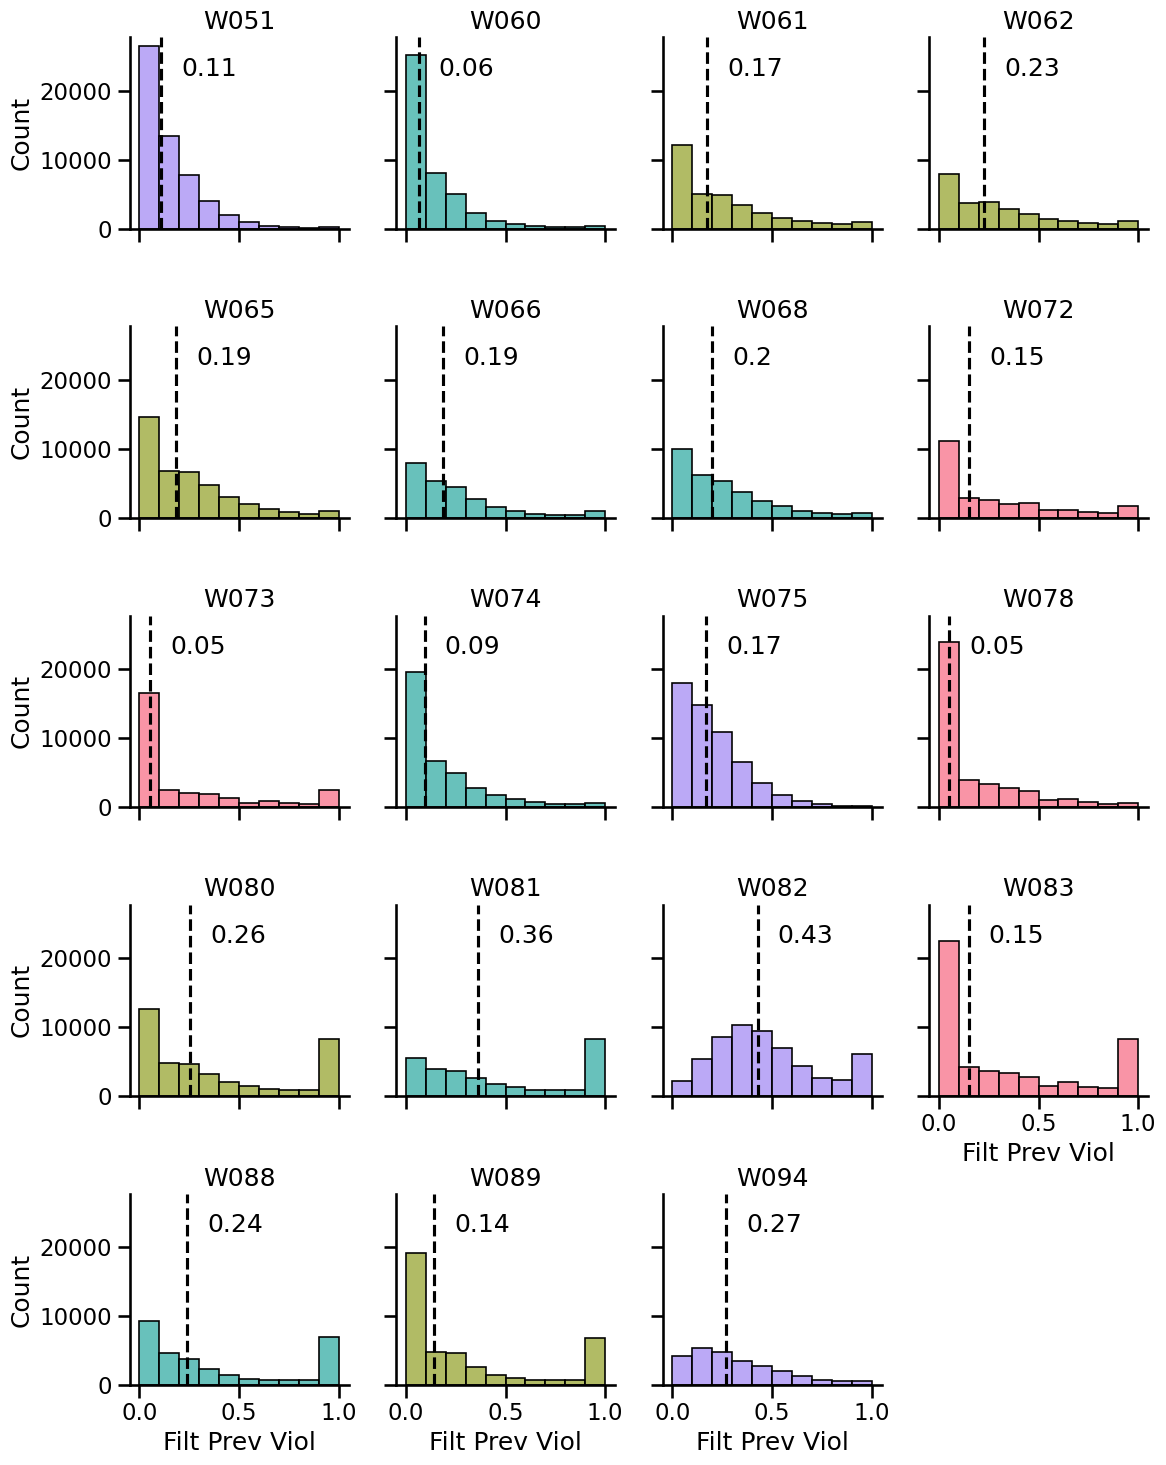

In [ ]:
g = plot_histogram_facet_grid(
    prev_violation_df,
    "prev_violation_exp",
    binwidth=0.1,
    hue="prev_violation_tau",
    palette="husl",
)
g.map_dataframe(plot_prev_viol_median)
g.set_axis_labels("Filt Prev Viol", "Count")
g.set_titles("{col_name}")

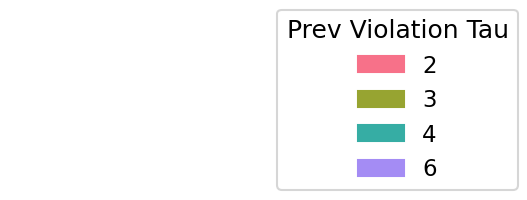

In [ ]:
plot_prev_viol_tau_palette()

This is fascinating- the shapes of these distributions really seem to vary from animal to animal. It would be interesting to see the relationship between median & TTT as well as final hit rate. Moreover, I want to get an idea for violation iti for each animal. It appears that the peak at 1 would mean some of these animals will violate a lot in a row while others do not.

### Plot Violation ITI for each animal

I want to make a histogram for each animal with distribution of violation ITIs. I then want to color that by tau and plot it against the histogram found above.

In [30]:
viol_iti_df = create_trials_df_w_viol_iti()

returning viol dataset for all animals


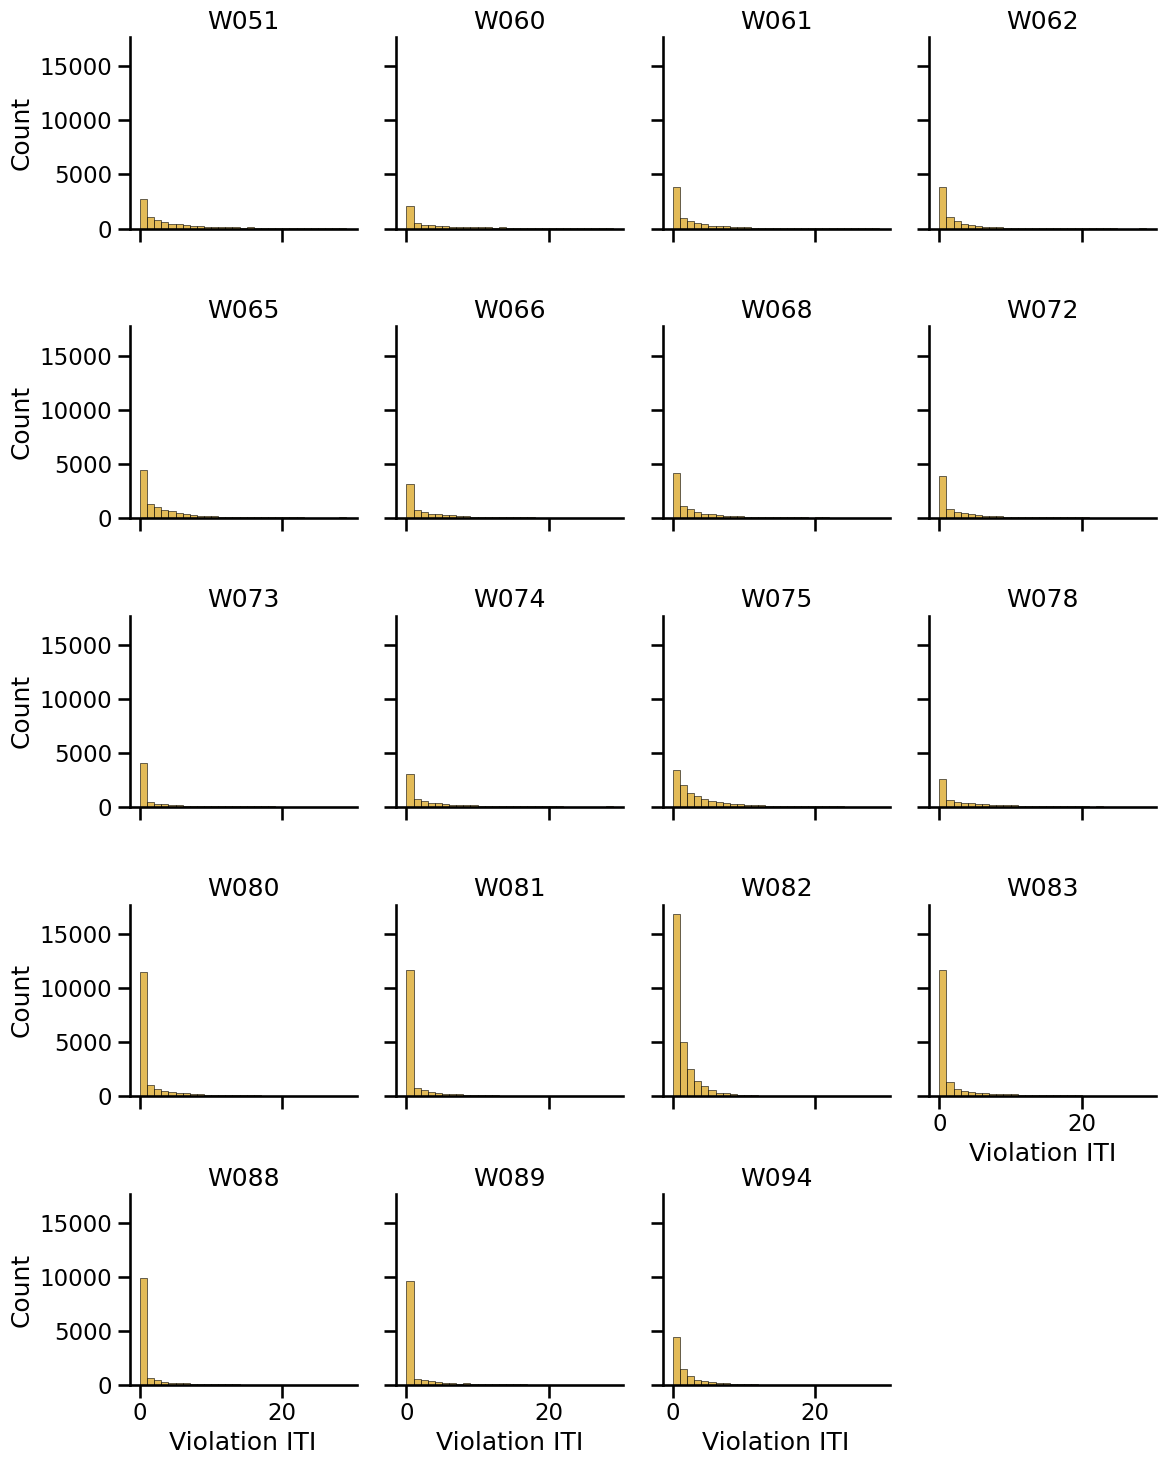

In [ ]:
g = plot_histogram_facet_grid(
    viol_iti_df.query("violation_iti < 30"),
    "violation_iti",
    binwidth=1,
    color="goldenrod",
)
g.set_axis_labels("Violation ITI", "Count")
g.set_titles("{col_name}")

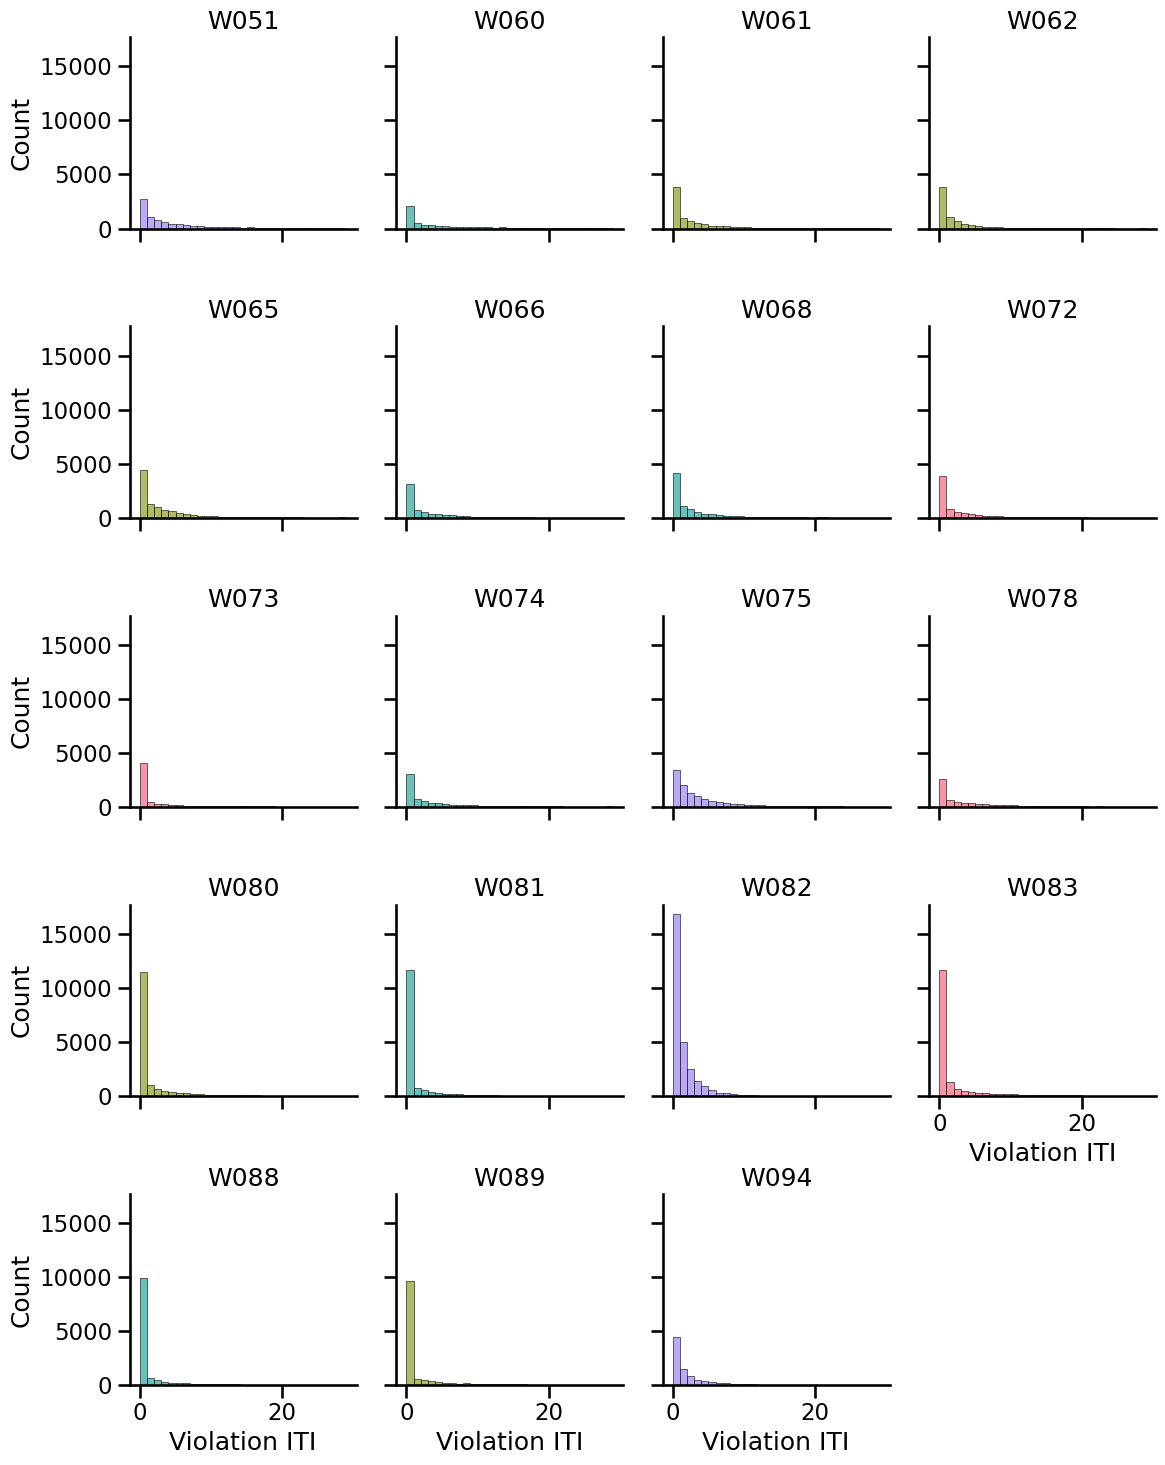

In [ ]:
g = plot_histogram_facet_grid(
    viol_iti_df.query("violation_iti < 30"),
    "violation_iti",
    binwidth=1,
    hue="prev_violation_tau",
    palette="husl",
)
g.set_axis_labels("Violation ITI", "Count")
g.set_titles("{col_name}")

Okay- so it looks like there are a lot of trials where a violation happens in a row. You can see this by the large spike at violation_iti = 0. This means "last trial was a violation". This makes sense given the success of the prev_violation regressor. However, we know that there is information for more than just the previous trial (because an exp filtered regressor does better than just prev_violation 1/0). And, we are interested in determining if violations happen in clumps (or blocks). 

To this end, I want to determine the fraction of trials where the iti is 0 in other words: of the violation trials, how many are happening in a row? Then I want to move into analysis of continuous violations or streaks of violations to see how long they are.

In [31]:
create_frac_consecutive_viols_df(viol_iti_df)

animal_id  frac_consecutive_viols
0       W051                0.317155
1       W060                0.348510
2       W061                0.459635
3       W062                0.496616
4       W065                0.424086
5       W066                0.466488
6       W068                0.469914
7       W072                0.521851
8       W073                0.598934
9       W074                0.436707
10      W075                0.294624
11      W078                0.378011
12      W080                0.729683
13      W081                0.785945
14      W082                0.592376
15      W083                0.690630
16      W088                0.761605
17      W089                0.723678
18      W094                0.491710

In [26]:
def create_viol_features_summary_df(viol_iti_df, prev_violation_df):
    """
    Function that creates a summary dataframe with the following columns:
    - animal_id
    - frac_consecutive_viols
    - median_prev_viol_exp
    - mean_prev_viol_exp
    - quartile_25_prev_viol_exp
    - quartile_75_prev_viol_exp
    - prev_violation_tau
    - session_avg_viol_rate
    - session_avg_hit_rate

    with animals as row index

    NOTE: this is a great function to update if you want to add in additional
    variables like time to train or final hit rate

    params
    ------
    viol_iti_df: pd.DataFrame
        this is a raw trials dataframe from get_rat_viol_data()
        wth the violation iti data added by create_trials_df_w_viol_iti()

    prev_violation_df: pd.DataFrame
        this is a design matrix with the filtered previous violation history
        generated by generate_design_mat_with_filter_viol()

    NOTE: both dataframes have animal_id, session, trial as the row index,
    it's just the columns that are different due to the design matrix creation

    returns
    -------
    summary_df: pd.DataFrame
        summary dataframe with columns described above

    """
    # create a dataframe with the fraction of violations with ITI = 0
    summary_df = create_frac_consecutive_viols_df(viol_iti_df)

    # add the median of the filtered previous violation history
    summary_df["median_prev_viol_exp"] = summary_df["animal_id"].map(
        prev_violation_df.groupby("animal_id").prev_violation_exp.median()
    )

    # add the mean of the filtered previous violation history
    summary_df["mean_prev_viol_exp"] = summary_df["animal_id"].map(
        prev_violation_df.groupby("animal_id").prev_violation_exp.mean()
    )

    summary_df["prev_violation_tau"] = summary_df["animal_id"].map(
        prev_violation_df.groupby("animal_id").prev_violation_tau.max()
    )

    summary_df["quartile_25_prev_viol_exp"] = summary_df["animal_id"].map(
        prev_violation_df.groupby("animal_id").prev_violation_exp.quantile(0.25)
    )

    summary_df["quartile_75_prev_viol_exp"] = summary_df["animal_id"].map(
        prev_violation_df.groupby("animal_id").prev_violation_exp.quantile(0.75)
    )

    summary_df["session_avg_viol_rate"] = summary_df["animal_id"].map(
        viol_iti_df.groupby(["animal_id", "session"])
        .violation.mean()
        .reset_index()
        .groupby("animal_id")
        .violation.mean()
    )

    summary_df["session_avg_hit_rate"] = summary_df["animal_id"].map(
        viol_iti_df.groupby(["animal_id", "session"])
        .hit.mean()
        .reset_index()
        .groupby("animal_id")
        .hit.mean()
    )

    return summary_df

In [43]:
summary_viol_df = create_viol_features_summary_df(viol_iti_df, prev_violation_df)
summary_viol_df.head()

animal_id  frac_consecutive_viols  median_prev_viol_exp  mean_prev_viol_exp   
0      W051                0.317155              0.109776            0.148744  \
1      W060                0.348510              0.063805            0.128098   
2      W061                0.459635              0.173599            0.244069   
3      W062                0.496616              0.226753            0.291036   
4      W065                0.424086              0.185149            0.242380   

   prev_violation_tau  quartile_25_prev_viol_exp  quartile_75_prev_viol_exp   
0                   6                   0.029193                   0.217896  \
1                   4                   0.008635                   0.187123   
2                   3                   0.041307                   0.361198   
3                   3                   0.064085                   0.440889   
4                   3                   0.048805                   0.360113   

   session_avg_viol_rate  session_avg_hit_rate  
0               0.182341              0.642214  
1               0.170187              0.702391  
2               0.329919              0.585271  
3               0.351805              0.575854  
4               0.260968              0.718271

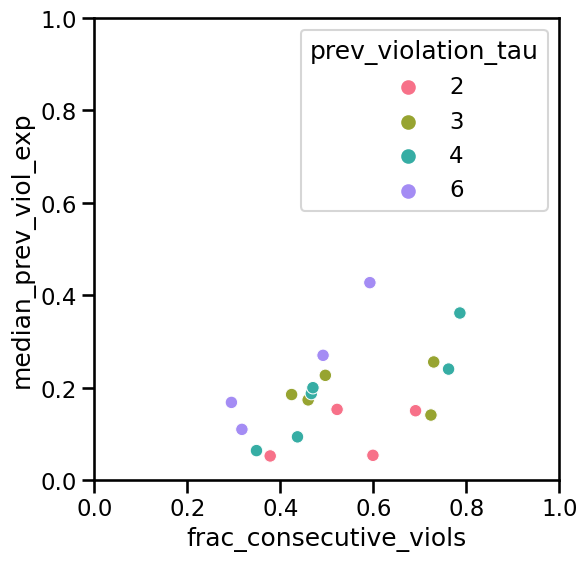

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.scatterplot(
    data=summary_viol_df,
    x="frac_consecutive_viols",
    y="median_prev_viol_exp",
    hue="prev_violation_tau",
    palette=sns.color_palette("husl", 4),
    ax=ax,
)

_ = ax.set(xlim=(0, 1), ylim=(0, 1))

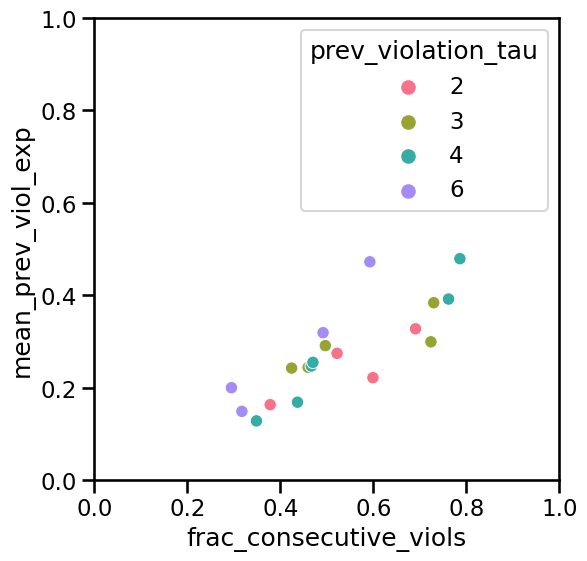

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.scatterplot(
    data=summary_viol_df,
    x="frac_consecutive_viols",
    y="mean_prev_viol_exp",
    hue="prev_violation_tau",
    palette=sns.color_palette("husl", 4),
    ax=ax,
)

_ = ax.set(xlim=(0, 1), ylim=(0, 1))

This plot is related to the histograms above. For an animal (single dot), as the fraction of consecutive violation trials increases, so does the median and the mean of prev_violation filter. This makes sense because when a consecutive violation happens, the filter will not decay and instead stay close to 1, which draws both these metrics up. 

The mean seems to be more correlated with the consecutive violations. It appears that the tau of the filter explains some variance in the line that is perpendicular to the line of best fit (i.e. PCA2).

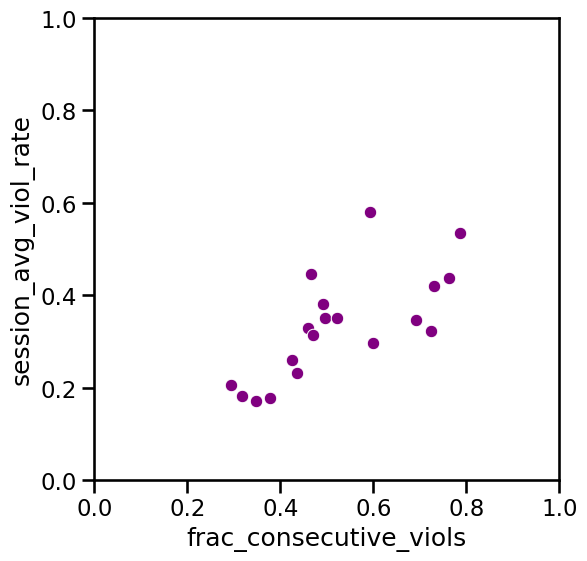

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.scatterplot(
    data=summary_viol_df,
    x="frac_consecutive_viols",
    y="session_avg_viol_rate",
    ax=ax,
    color="purple",
)


_ = ax.set(xlim=(0, 1), ylim=(0, 1))

The fraction of consecutive violations is highly correlated with the session average violation rate. However, the fraction of consecutive violations is often higher than the session average rate (slightly under the unity line) according to this plot. A more granular analysis is needed imo.

**TODO**: implement this on an animal, session basis. So each dot represents an animal and session. Can color by animal

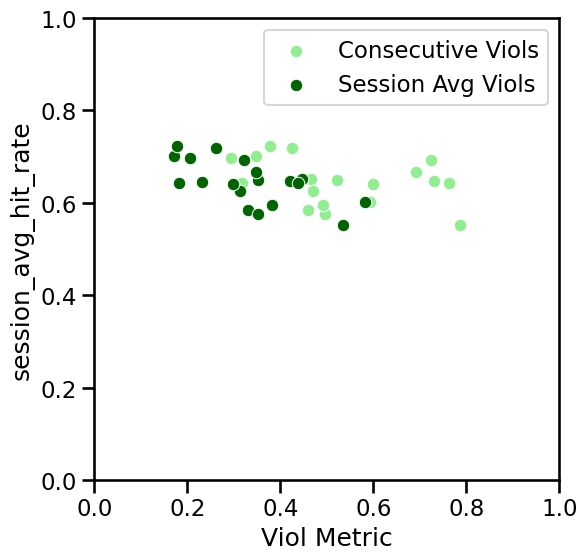

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.scatterplot(
    data=summary_viol_df,
    x="frac_consecutive_viols",
    y="session_avg_hit_rate",
    ax=ax,
    color="lightgreen",
    label="Consecutive Viols",
)

sns.scatterplot(
    data=summary_viol_df,
    x="session_avg_viol_rate",
    y="session_avg_hit_rate",
    ax=ax,
    color="darkgreen",
    label="Session Avg Viols",
)


_ = ax.set(xlim=(0, 1), ylim=(0, 1), xlabel="Viol Metric")

As seen in the plot above, the consecutive violations are higher values. However, they don't seem to have a stronger relationship with hit rate than the session average violation rate even though their range along the x-axis is a bit larger.

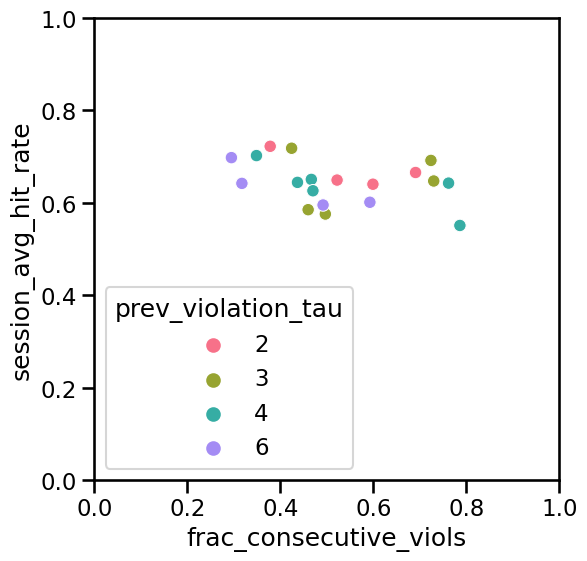

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.scatterplot(
    data=summary_viol_df,
    x="frac_consecutive_viols",
    y="session_avg_hit_rate",
    ax=ax,
    hue="prev_violation_tau",
    palette=sns.color_palette("husl", 4),
)


_ = ax.set(xlim=(0, 1), ylim=(0, 1))

**TODO**: plot frac consecutive viols versus time to train! I wonder how correlated they are. This will requiring getting this info from another notebook.

#### Consecutive Violations

In [45]:
viol_iti_df = calculate_consecutive_violations(viol_iti_df)

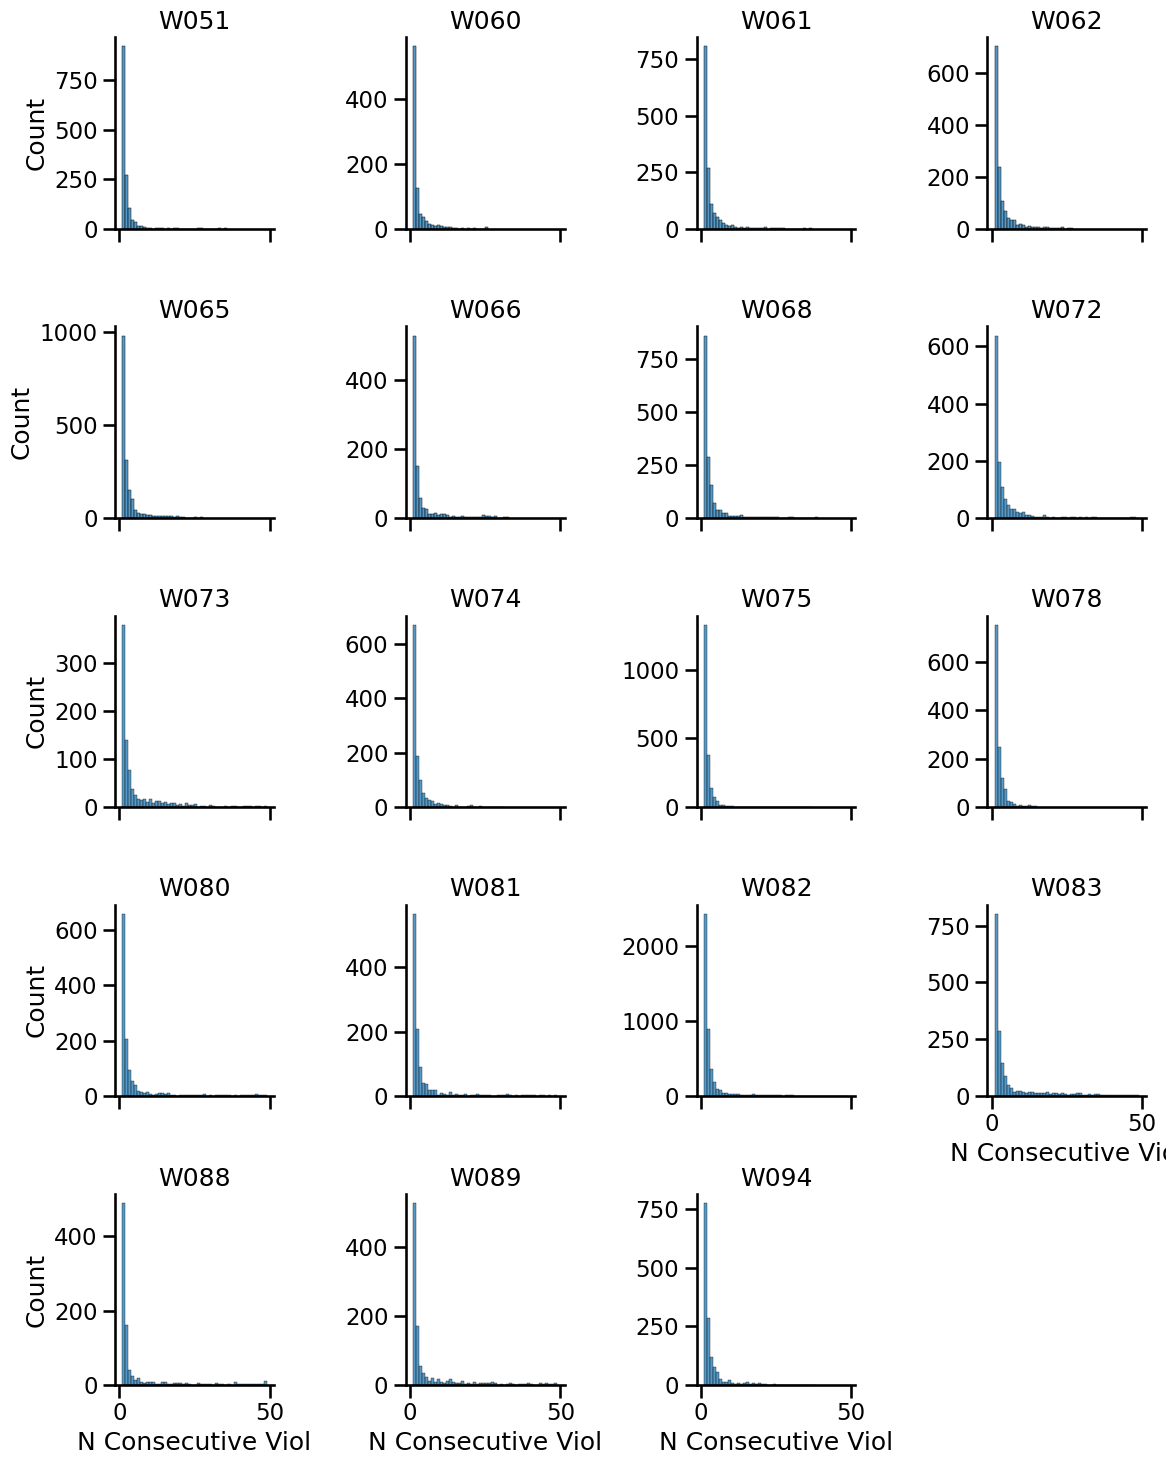

In [ ]:
# Now create the facet grid plot

g = plot_histogram_facet_grid(
    viol_iti_df.query("n_consecutive_viols < 50"),
    "n_consecutive_viols",
    binwidth=1,
    sharey=False,
)
# Set titles and labels
g.set_axis_labels("N Consecutive Viol", "Count")
g.set_titles("{col_name}")

In [47]:
summary_viol_df["session_avg_mean_n_consecutive_viols"] = summary_viol_df[
    "animal_id"
].map(
    viol_iti_df.groupby(["animal_id", "session"])
    .n_consecutive_viols.mean()
    .reset_index()
    .groupby("animal_id")
    .n_consecutive_viols.mean()
)

In [48]:
summary_viol_df.columns

Index(['animal_id', 'frac_consecutive_viols', 'median_prev_viol_exp',
       'mean_prev_viol_exp', 'prev_violation_tau', 'quartile_25_prev_viol_exp',
       'quartile_75_prev_viol_exp', 'session_avg_viol_rate',
       'session_avg_hit_rate', 'session_avg_mean_n_consecutive_viols'],
      dtype='object')

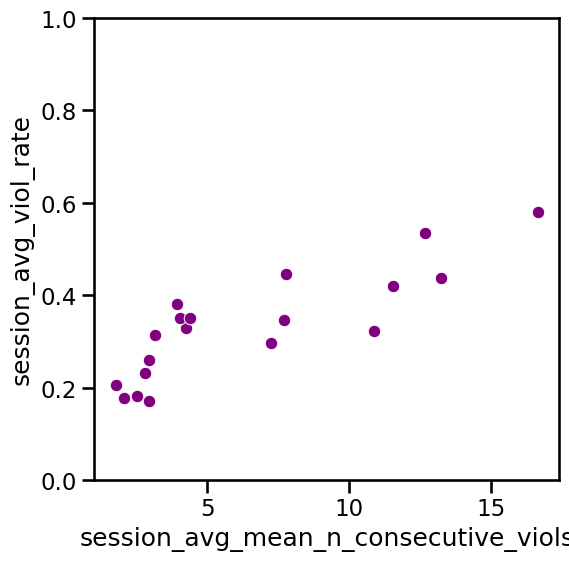

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.scatterplot(
    data=summary_viol_df,
    x="session_avg_mean_n_consecutive_viols",
    y="session_avg_viol_rate",
    ax=ax,
    color="purple",
)


_ = ax.set(ylim=(0, 1))

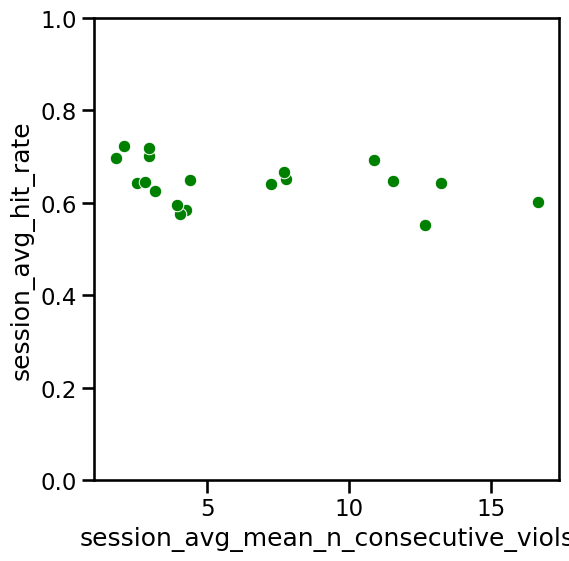

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.scatterplot(
    data=summary_viol_df,
    x="session_avg_mean_n_consecutive_viols",
    y="session_avg_hit_rate",
    ax=ax,
    color="green",
)


_ = ax.set(ylim=(0, 1))

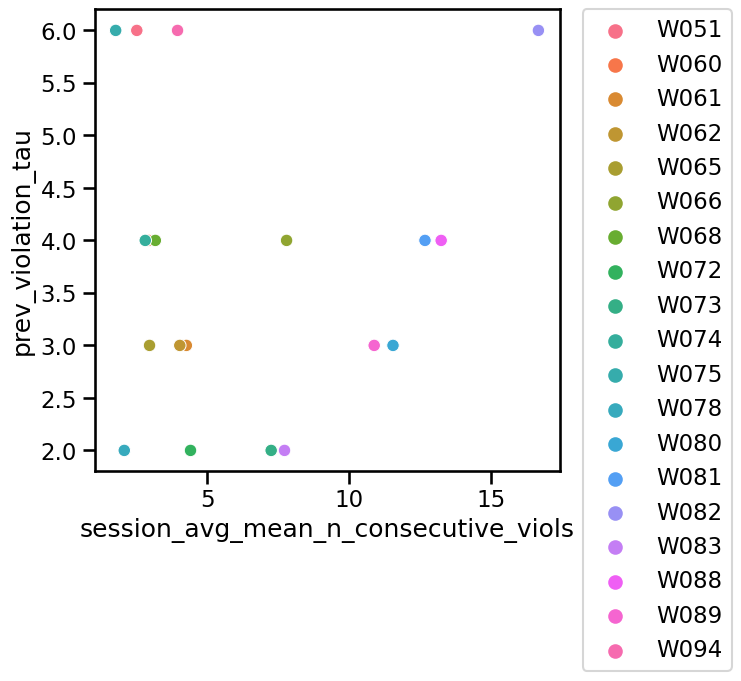

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.scatterplot(
    data=summary_viol_df,
    x="session_avg_mean_n_consecutive_viols",
    y="prev_violation_tau",
    ax=ax,
    hue="animal_id",
)

# move legend over
_ = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

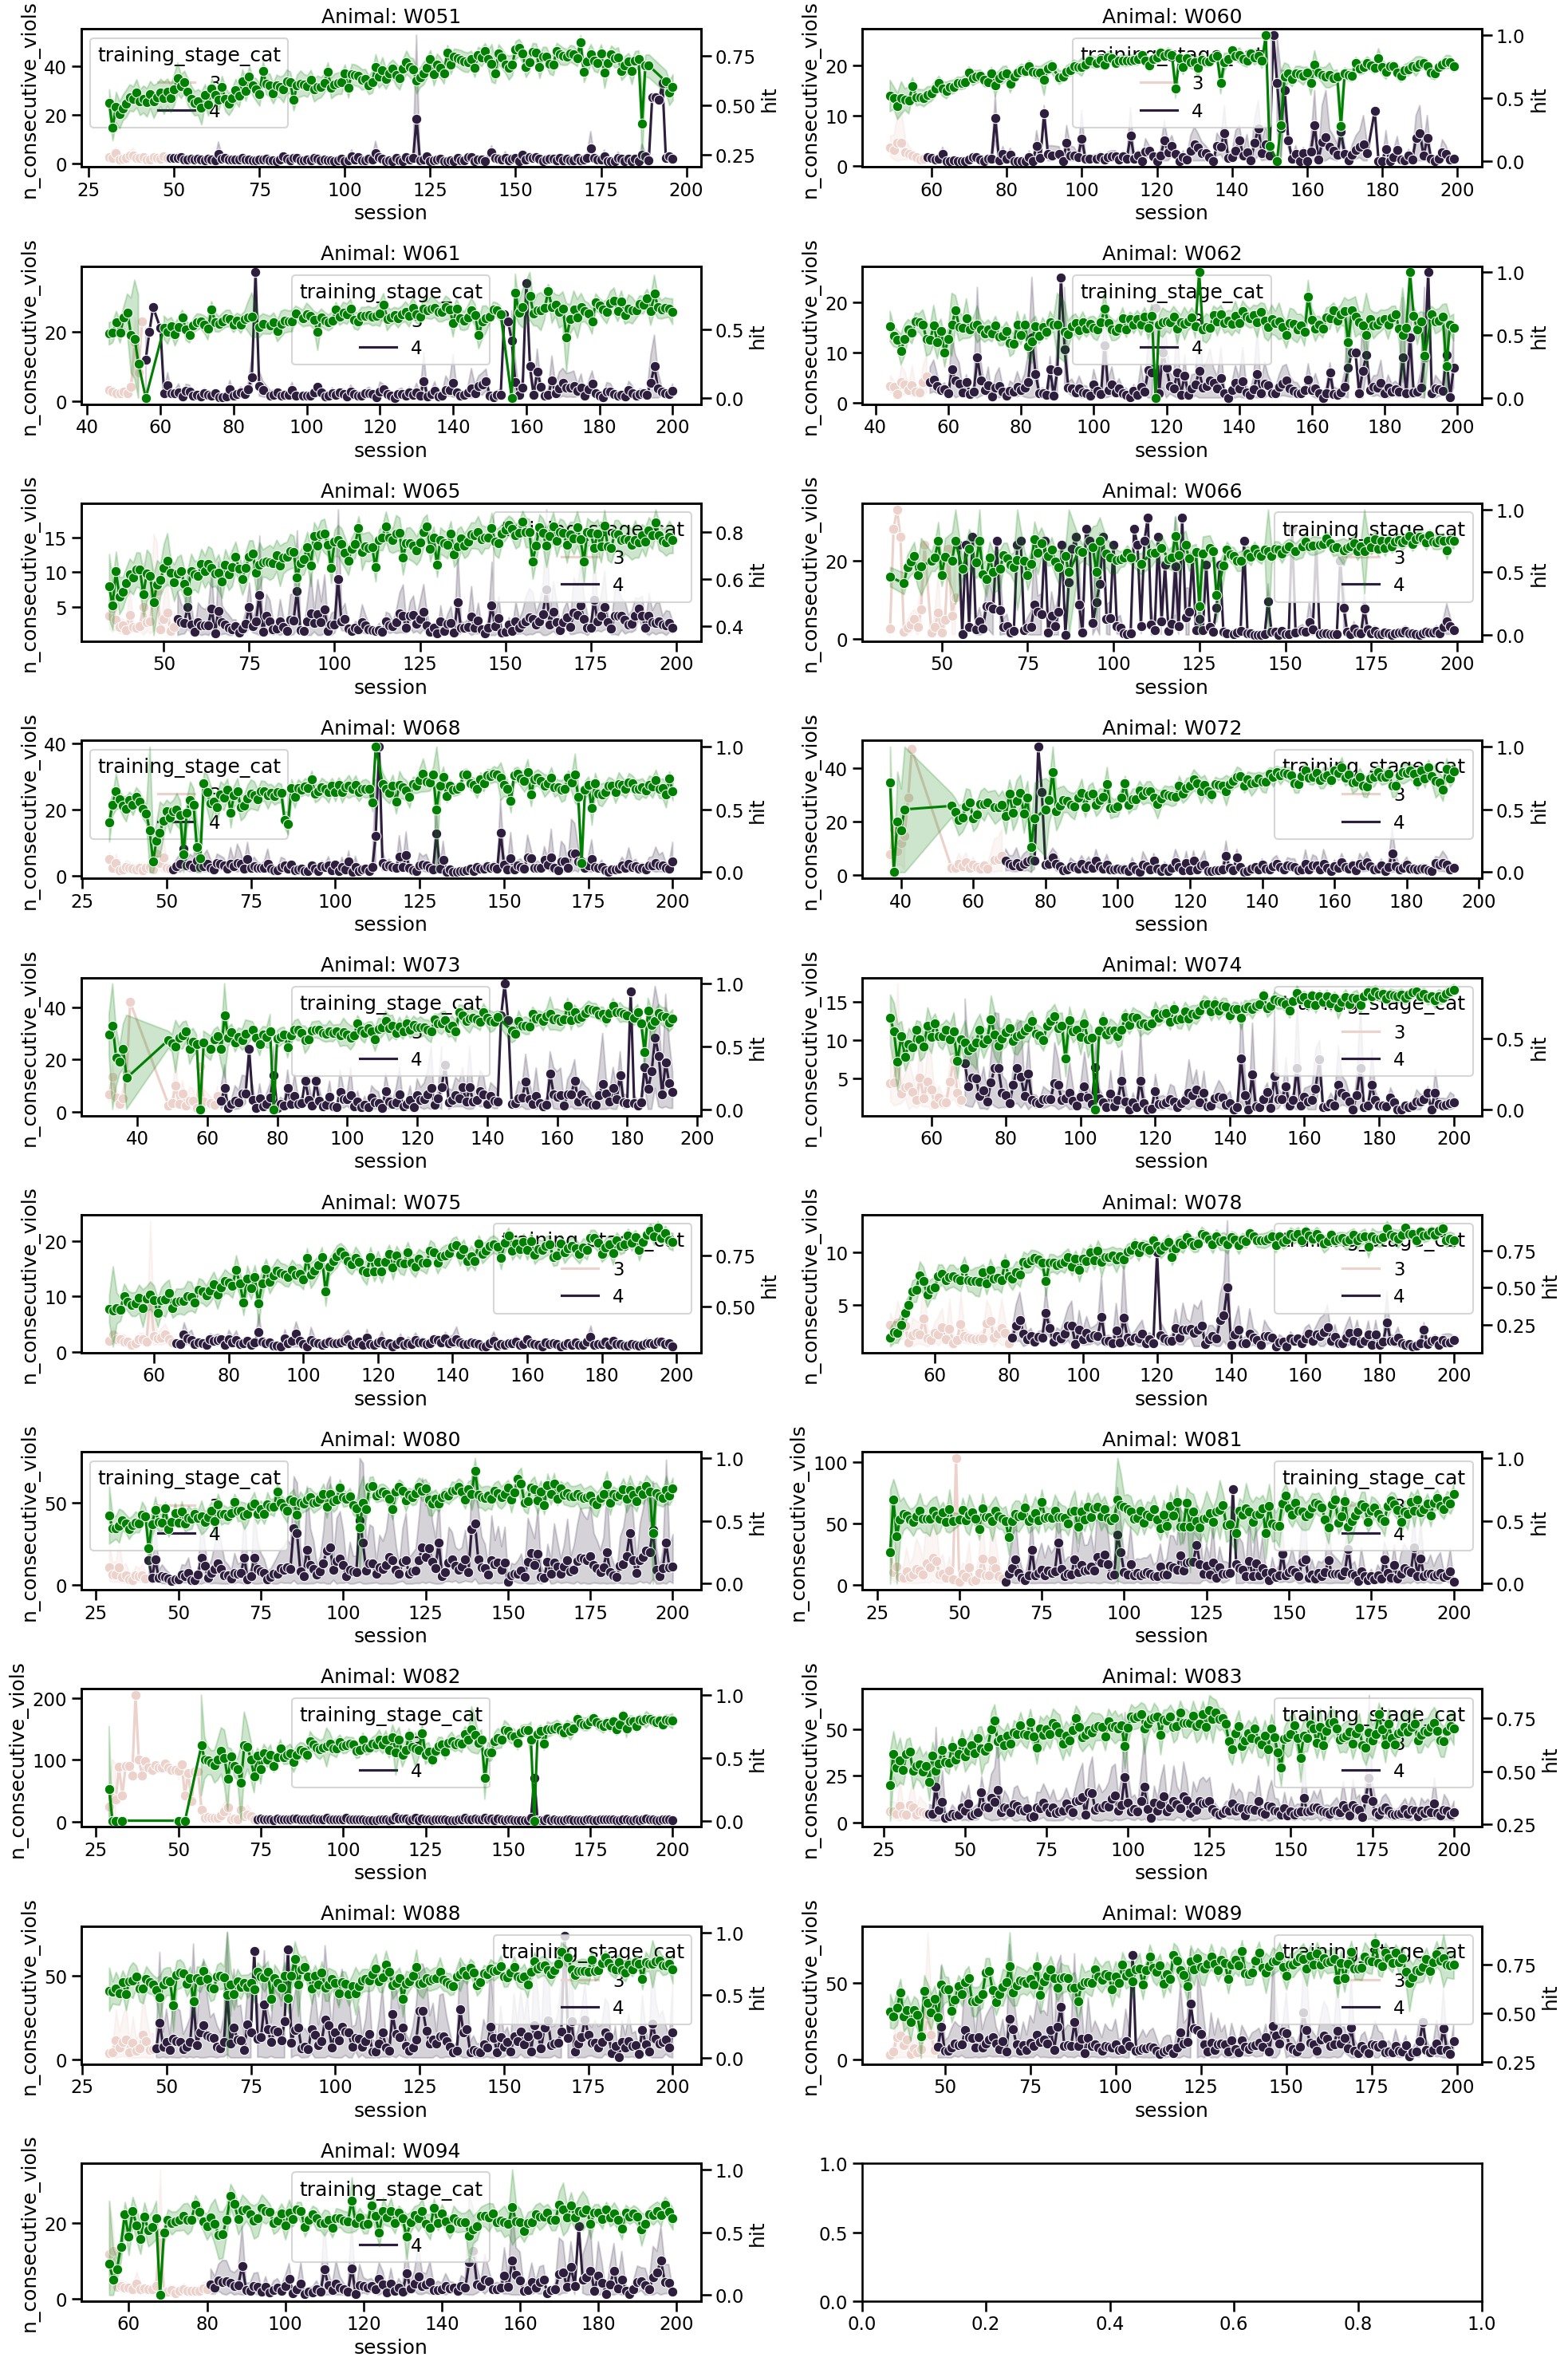

In [ ]:
# Get a list of unique animals
animals = viol_iti_df["animal_id"].unique()

# Determine the number of rows/columns for the subplot grid
n_rows = len(animals) // 2 + len(animals) % 2
n_cols = 2

# Create a figure with subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 3 * n_rows))

# Flatten the axs array for easy iteration
axs = axs.flatten()

for idx, animal in enumerate(animals):
    ax = axs[idx]

    # Plot the first lineplot on ax
    sns.lineplot(
        data=viol_iti_df.query(f"animal_id == '{animal}'"),
        x="session",
        y="n_consecutive_viols",
        marker="o",
        ax=ax,
        hue="training_stage_cat",
    )

    # Create a secondary axis for the second lineplot
    ax2 = ax.twinx()

    sns.lineplot(
        data=viol_iti_df.query(f"animal_id == '{animal}'"),
        x="session",
        y="hit",
        marker="o",
        ax=ax2,
        color="green",
    )

    # Optional: Set a title for each subplot
    ax.set_title(f"Animal: {animal}")

# Adjust layout for better viewing
plt.tight_layout()

It looks like there are three animals (W082, W072, W073) where they in stage 3 have multiple sessions where the violation streaks are very high and hits are near 0 or completely Nan. I wonder if these sessions should be removed in future analyses, or perhaps just looking at stage 3.

Moreover, I am a bit concerned that some of these violations are timeout trials, which is motivating me to potentially re-make the dataset.

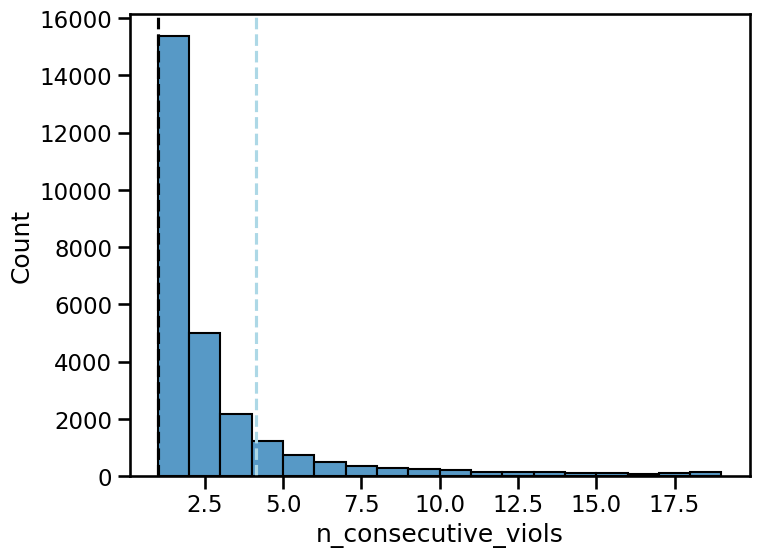

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.histplot(
    viol_iti_df.query("n_consecutive_viols < 20"),
    x="n_consecutive_viols",
    # element="step",
    binwidth=1,
)

ax.axvline(viol_iti_df.n_consecutive_viols.median(), color="black", ls="--")
ax.axvline(viol_iti_df.n_consecutive_viols.mean(), color="lightblue", ls="--")

This is collapsed across all animals and sessions and truncated at 20 in a row. The median is 1 and the mean is around 4.2 trials. This explains why the filtered history does well and supports the filtered history being an expontential kernel. I think this plot would be useful in motivation.

In [50]:
f_name = "2023_12_10_summary_viol_df.csv"

summary_viol_df.to_csv(results_path + f_name, index=False)
summary_viol_df.head()

animal_id  frac_consecutive_viols  median_prev_viol_exp  mean_prev_viol_exp   
0      W051                0.317155              0.109776            0.148744  \
1      W060                0.348510              0.063805            0.128098   
2      W061                0.459635              0.173599            0.244069   
3      W062                0.496616              0.226753            0.291036   
4      W065                0.424086              0.185149            0.242380   

   prev_violation_tau  quartile_25_prev_viol_exp  quartile_75_prev_viol_exp   
0                   6                   0.029193                   0.217896  \
1                   4                   0.008635                   0.187123   
2                   3                   0.041307                   0.361198   
3                   3                   0.064085                   0.440889   
4                   3                   0.048805                   0.360113   

   session_avg_viol_rate  session_avg_hit_rate   
0               0.182341              0.642214  \
1               0.170187              0.702391   
2               0.329919              0.585271   
3               0.351805              0.575854   
4               0.260968              0.718271   

   session_avg_mean_n_consecutive_viols  
0                              2.518311  
1                              2.937218  
2                              4.263279  
3                              4.032330  
4                              2.967139

## Psychometrics

### Fit to raw data

In [18]:
viol_df = get_rat_viol_data().query("training_stage_cat > 2").copy()
viol_df["delta_stim"] = viol_df.s_a - viol_df.s_b
viol_df.groupby("animal_id").delta_stim.unique()

returning viol dataset for all animals


animal_id
W051    [-8.0, 8.0]
W060    [8.0, -8.0]
W061    [-8.0, 8.0]
W062    [8.0, -8.0]
W065    [-8.0, 8.0]
W066    [8.0, -8.0]
W068    [-8.0, 8.0]
W072    [-8.0, 8.0]
W073    [8.0, -8.0]
W074    [-8.0, 8.0]
W075    [-8.0, 8.0]
W078    [8.0, -8.0]
W080    [-8.0, 8.0]
W081    [8.0, -8.0]
W082    [-8.0, 8.0]
W083    [8.0, -8.0]
W088    [8.0, -8.0]
W089    [8.0, -8.0]
W094    [-8.0, 8.0]
Name: delta_stim, dtype: object

This data confirms that up to the violation cut off (~session 200) there are only ladder stimuli shown- no psychometric stimuli. This is indicated by only having +/- 8 as the delta_stim values.

In [19]:
viol_df = get_rat_viol_data().query("training_stage_cat > 2").copy()
probs_right_session_df = compute_psych_df(viol_df, by_session=True)

returning viol dataset for all animals


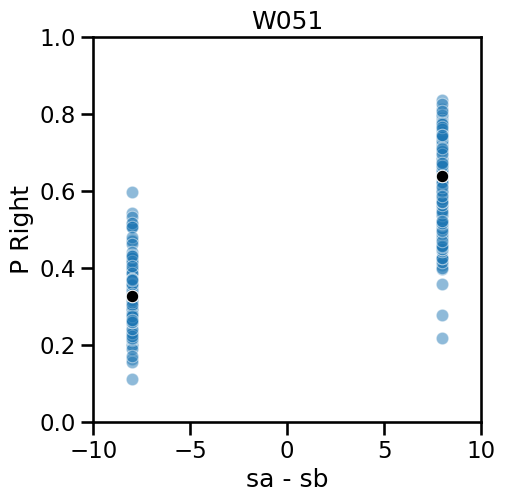

In [20]:
example_animal = "W051"

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(
    data=probs_right_session_df.query("animal_id == @example_animal"),
    x="delta_stim",
    y="p_right",
    ax=ax,
    alpha=0.5,
)

sns.scatterplot(
    probs_right_session_df.query("animal_id == @example_animal")
    .groupby("delta_stim")
    .p_right.mean(),
    color="k",
)
_ = ax.set(
    xlabel="sa - sb",
    ylabel="P Right",
    ylim=(0, 1),
    xlim=(-10, 10),
    title=example_animal,
)

This plot shows the p(right) for each stimulus value, session for a given animal with the mean values across all sessions in black. The animal is doing the sack, however, it's difficult to fit a sigmoid due to the lack of variation in sa-sb magnitude.

/Users/jessbreda/anaconda3/envs/an_lrn/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/jessbreda/anaconda3/envs/an_lrn/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


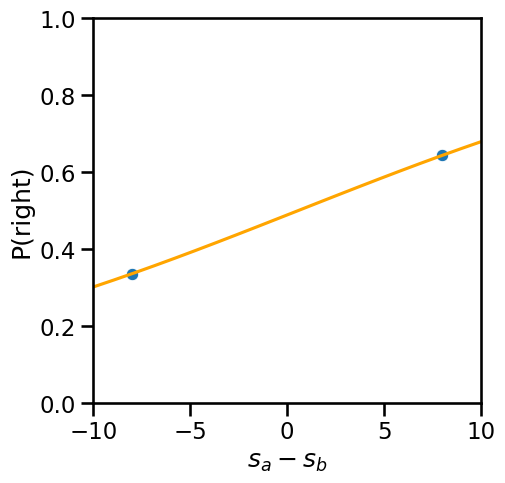

In [24]:
probs_right_df = compute_psych_df(viol_df, by_session=False)
x_vals, psych = fit_psych_(probs_right_df.query("animal_id == @example_animal"))
fig, ax = plt.subplots(figsize=(5, 5))
plot_fitted_psych(x_vals, psych, ax=ax, color="orange")
plot_raw_psych_data(probs_right_df.query("animal_id == @example_animal"), ax=ax)

Okay, I was able to find the probability of going right, and given the x, y data, fit a sigmoid to it using scipy. I then plotted the raw data (blue) and the fit data (orange). This is more of a mental exercise than a research question at this point, but I think this code will come in handy when I have access to psychometric stimuli.

The remaining todos for extending this are:
 * plot for each animal on a facet grid of sorts
 * incorporate session spread- each blue point above could have a variance across sessions. 
 
    * I had a chat gpt convo about this a while ago, where each sessions has an x-val and corresponding p(right) which is already in compute_psych_df(). However, the fitting and plotting of psych do not take this into account and would need to be modified.

### Simulate from GLM fits

#### Fit GLM

The first step here is to fit a GLM for each animal with interaction terms to get weights that will be used for simulated a psychometric.

In [ ]:
model_config = {
    "prev_violation_stim_intrx": {
        "model_class": MultiClassLogisticRegression,
        "model_type": "multi",
        "design_matrix_generator": DesignMatrixGeneratorInteractions,
        "design_matrix_generator_args": {
            "interaction_pairs": create_violation_interaction_pairs(["s_a", "s_b"])
        },
        "filter_implementation": {
            "prev_violation": 1
        },  # filter column with animals tau
    },
}

params = {
    "animals": None,
    "sigmas": [0.07, 0.13, 0.25, 0.5, 1, 2, 4, 8, 16],
    "random_state": 47,
    "eval_train": True,
    "model_config": model_config,
    "tau_columns": ["prev_violation"],
}

In [ ]:
# Commented out to freeze experiment and load from save in
# experiment = ExperimentSigmaSweep(params)
# experiment.run()
# experiment.save(file_name="2023_12_10_stim_violation_intrxs.pkl")

returning viol dataset for all animals

 >>>> evaluating animal W051 <<<<

 ***** evaluating model prev_violation_stim_intrx w/ sigma 0.07 *****
         Current function value: 41163.808690
         Iterations: 27
         Function evaluations: 78
         Gradient evaluations: 66

 ***** evaluating model prev_violation_stim_intrx w/ sigma 0.13 *****
Optimization terminated successfully.
         Current function value: 40733.110147
         Iterations: 29
         Function evaluations: 39
         Gradient evaluations: 39

 ***** evaluating model prev_violation_stim_intrx w/ sigma 0.25 *****
Optimization terminated successfully.
         Current function value: 40520.737100
         Iterations: 31
         Function evaluations: 40
         Gradient evaluations: 40

 ***** evaluating model prev_violation_stim_intrx w/ sigma 0.5 *****
Optimization terminated successfully.
         Current function value: 40447.561549
         Iterations: 29
         Function evaluations: 40
         Gr

In [2]:
import pickle

experiment_fname = "2023_12_10_stim_violation_intrxs.pkl"

with open(results_path + experiment_fname, "rb") as f:
    experiment = pickle.load(f)

mv = ModelVisualizer(experiment)

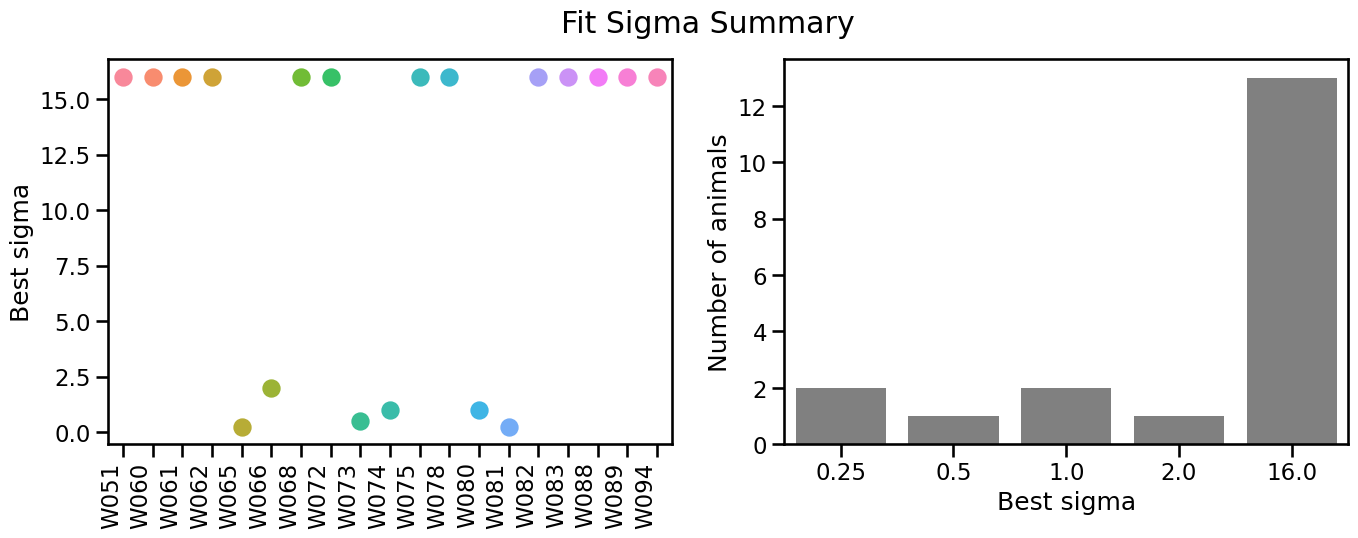

In [3]:
mv.plot_sigma_summary()

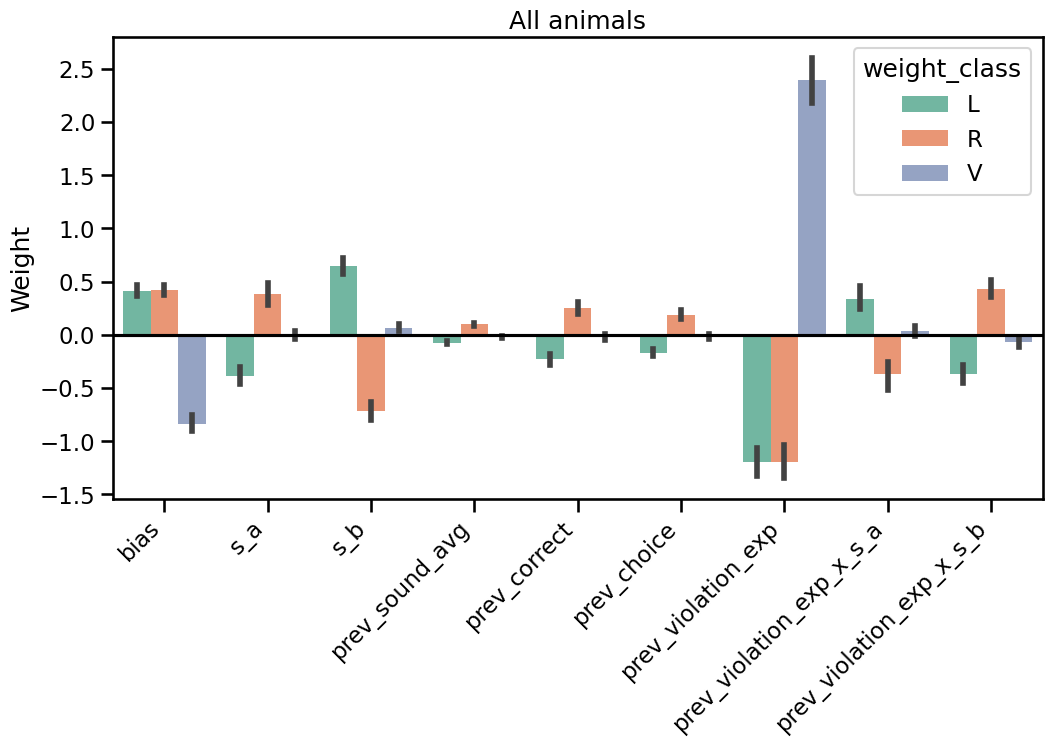

In [4]:
mv.plot_weights_summary(palette="Set2")

Okay great I was able to update the Experiment_sigma_sweep code and recreate the interaction term results. now, it's time to get the weights for the best sigma model for each animal. Specifically looking for the sa, sb and interaction term weights.

### Compute L - R weights

In [5]:
best_fit_df = mv.find_best_fit()
best_fit_df.head()

animal_id                 model_name           nll     train_nll  sigma   
0      W051  prev_violation_stim_intrx  10663.789104  40421.265454  16.00  \
1      W060  prev_violation_stim_intrx   7133.894558  29241.132219  16.00   
2      W061  prev_violation_stim_intrx   6174.416475  24999.936297  16.00   
3      W062  prev_violation_stim_intrx   5003.037052  19757.247492  16.00   
4      W065  prev_violation_stim_intrx   7924.895022  29613.132673   0.25   

                                            features   
0  [bias, s_a, s_b, prev_sound_avg, prev_correct,...  \
1  [bias, s_a, s_b, prev_sound_avg, prev_correct,...   
2  [bias, s_a, s_b, prev_sound_avg, prev_correct,...   
3  [bias, s_a, s_b, prev_sound_avg, prev_correct,...   
4  [bias, s_a, s_b, prev_sound_avg, prev_correct,...   

                                             weights  n_train_trials   
0  [[0.49202599790271706, 0.5665055913501791, -1....           43824  \
1  [[0.525123655919572, 0.5667338839748565, -1.09...           35232   
2  [[0.3512949303121718, 0.38453300320045336, -0....           26284   
3  [[0.31914684040596475, 0.3368115029204723, -0....           20398   
4  [[0.2772553032942767, 0.33431945652056305, -0....           32548   

   n_test_trials  prev_violation_tau  
0          11609                 6.0  
1           8157                 4.0  
2           6285                 3.0  
3           5237                 3.0  
4           8795                 3.0

In [6]:
features_of_interest = [
    "bias",
    "s_a",
    "s_b",
    "prev_violation_exp_x_s_a",
    "prev_violation_exp_x_s_b",
]
weight_class_of_interest = ["L", "R"]

flattened_df = mv.unpack_features_and_weights(best_fit_df)

flattened_df = flattened_df.query(
    "feature in @features_of_interest and weight_class in @weight_class_of_interest"
).copy()

In [7]:
delta_weights_df = pd.DataFrame(
    columns=["animal_id", "feature", "weight", "weight_class"]
)
for (aid, feature), sub_df in flattened_df.groupby(["animal_id", "feature"]):
    L_weights = sub_df.query("weight_class == 'L'").weight.values[0]
    R_weights = sub_df.query("weight_class == 'R'").weight.values[0]
    weight_diff = R_weights - L_weights

    data = {
        "animal_id": aid,
        "feature": feature,
        "weight": weight_diff,
        "weight_class": "R-L",
    }
    idx = len(delta_weights_df)
    for key, value in data.items():
        delta_weights_df.loc[idx, key] = value

In [8]:
delta_weights_df.head()

animal_id                   feature    weight weight_class
0      W051                      bias   0.07448          R-L
1      W051  prev_violation_exp_x_s_a -1.635959          R-L
2      W051  prev_violation_exp_x_s_b  1.616115          R-L
3      W051                       s_a  0.961242          R-L
4      W051                       s_b -1.187777          R-L

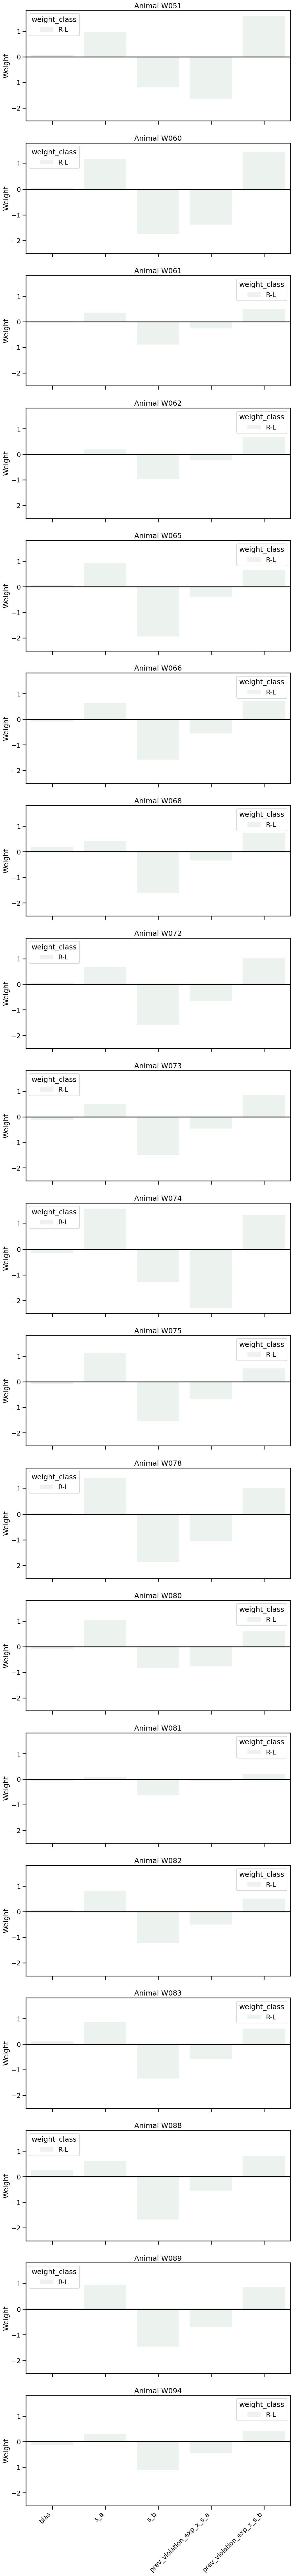

In [9]:
mv.plot_weights_by_animal(
    delta_weights_df, order=features_of_interest, color="mediumseagreen"
)

In [10]:
delta_weights_df

animal_id                   feature    weight weight_class
0       W051                      bias   0.07448          R-L
1       W051  prev_violation_exp_x_s_a -1.635959          R-L
2       W051  prev_violation_exp_x_s_b  1.616115          R-L
3       W051                       s_a  0.961242          R-L
4       W051                       s_b -1.187777          R-L
..       ...                       ...       ...          ...
90      W094                      bias -0.116636          R-L
91      W094  prev_violation_exp_x_s_a -0.441084          R-L
92      W094  prev_violation_exp_x_s_b    0.4311          R-L
93      W094                       s_a  0.298568          R-L
94      W094                       s_b -1.117821          R-L

[95 rows x 4 columns]

### Simulate psychometrics

1. for a single animal, with only sa/sb terms
2. generate x values (sa, sb pairs) from range
2. write a function for simulate psychometric from weights
    * takes in x vals, delta_weights, interaction bool that plots psychometric given jpillow equation

$$ z = [w_{s_a} + (w_{s_a intrx} * f_x)] * s_a + [w_{sb} + (w_{s_b intrx} * f_x)] * s_b $$

where 

$s_a$ = stimulus a*

$s_b$ = stimulus b* 

$f_x$ = prev violation filter regressor (fixed at 0 or 1)

$w_{s_a}, w_{s_b}$ = stimulus weights

$w_{s_a intrx}, w_{s_b intrx}$ = stim x violation interaction weight

$p(\text{right}) = \frac{1}{1 + e^{-z}}$

#### x vals

X is a n by d matrix where d in this case is 2 (s_a and s_b stimulus values). The current implementation does not take into account a bias term.

returning full dataset for all animals


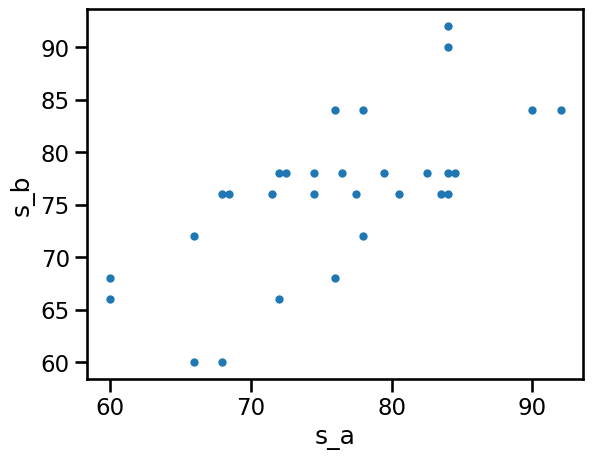

In [11]:
from get_rat_data import get_rat_data

rat_df = get_rat_data()
pair_counts = rat_df.groupby(["s_a", "s_b"]).size().reset_index(name="count")
pair_counts.plot(
    x="s_a",
    y="s_b",
    kind="scatter",
)

X = pair_counts[["s_a", "s_b"]]

In [12]:
X_enhanced = generate_x_data()

Okay, now x data has been generate in a grid of s_a - s_b differences that has been bound by the norm of the actual data (which span from -8, 8 and normalizes to -2, 2). Let's see if we can extract the weights for a single animal in a sub_df and plot it's psychometric. 

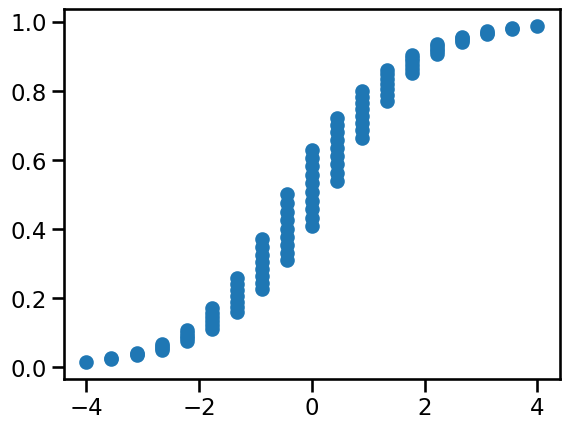

In [13]:
# Init
animal_id = "W051"
sub_df = delta_weights_df.query("animal_id == @animal_id").copy()
filter_on = False

# Extract weights
w_sa = sub_df.loc[sub_df["feature"] == "s_a", "weight"].values[0]
w_sb = sub_df.loc[sub_df["feature"] == "s_b", "weight"].values[0]
w_sa_x = sub_df.loc[sub_df["feature"] == "prev_violation_exp_x_s_a", "weight"].values[0]
w_sb_x = sub_df.loc[sub_df["feature"] == "prev_violation_exp_x_s_b", "weight"].values[0]
bias = sub_df.loc[sub_df["feature"] == "bias", "weight"].values[0]
# Filter control
f_x = 1 if filter_on else 0

# Vectorized computation of z
z = ((w_sa + (w_sa_x * f_x)) * X_enhanced["s_a"]) + (
    (w_sb + (w_sb_x * f_x)) * X_enhanced["s_b"] + bias
)


# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


# Apply sigmoid function to z
ys = sigmoid(z)

# Delta x computation (if needed)
deltax = X_enhanced["s_a"] - X_enhanced["s_b"]

plt.scatter(deltax, ys)

Great- that looks good to me. Let's see if we can do this for different filter $f_x$ values (0, 1, animal's median) across animals.

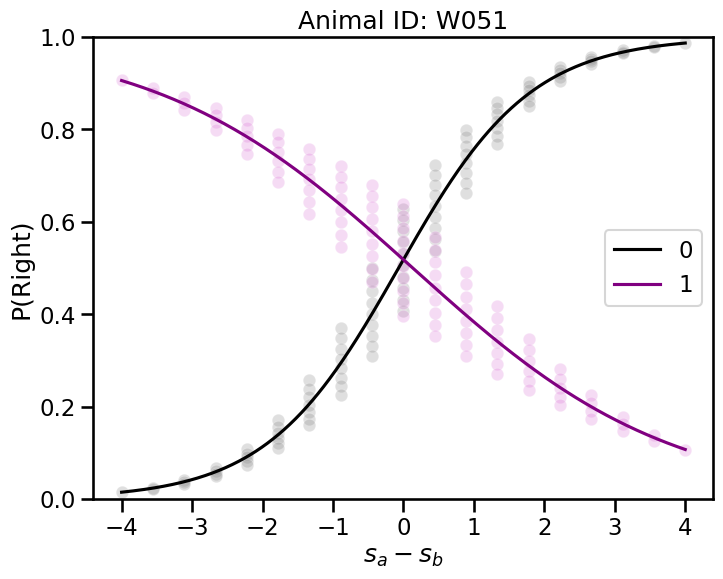

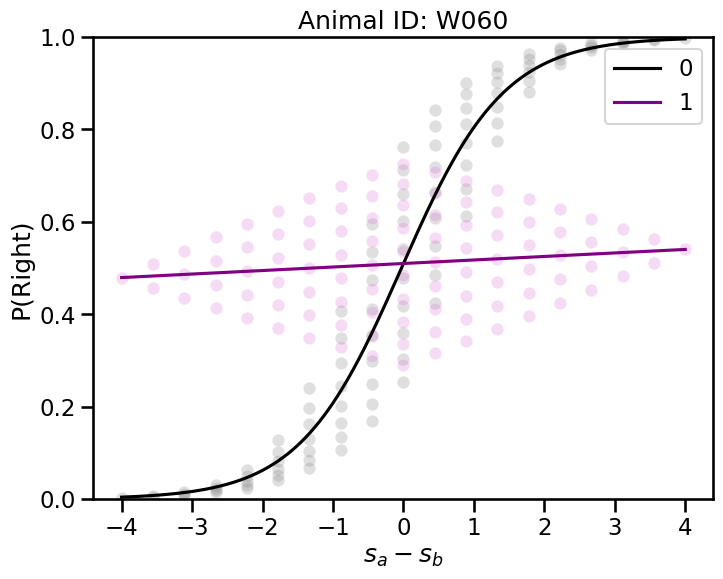

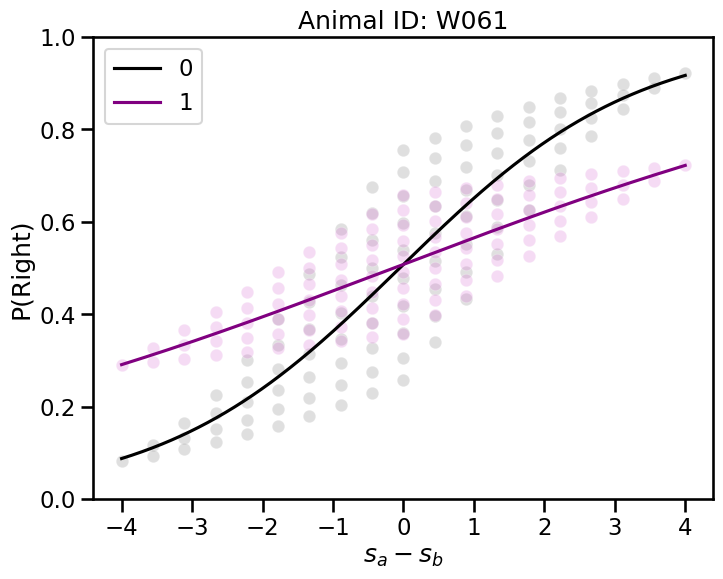

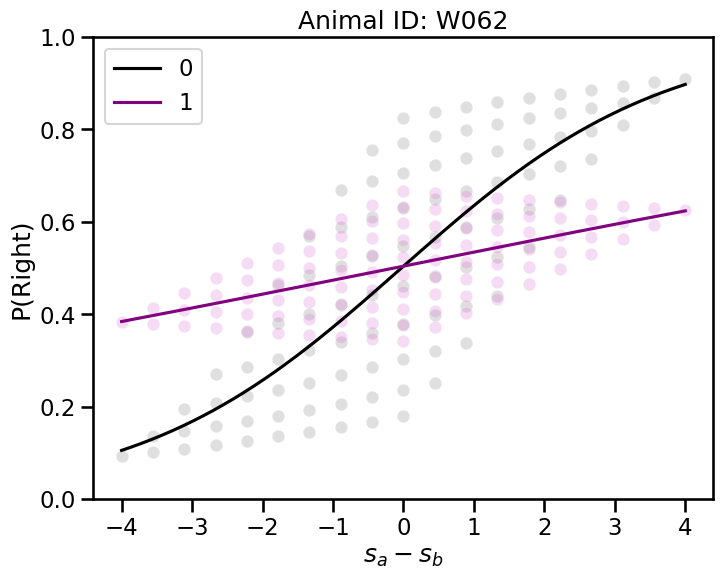

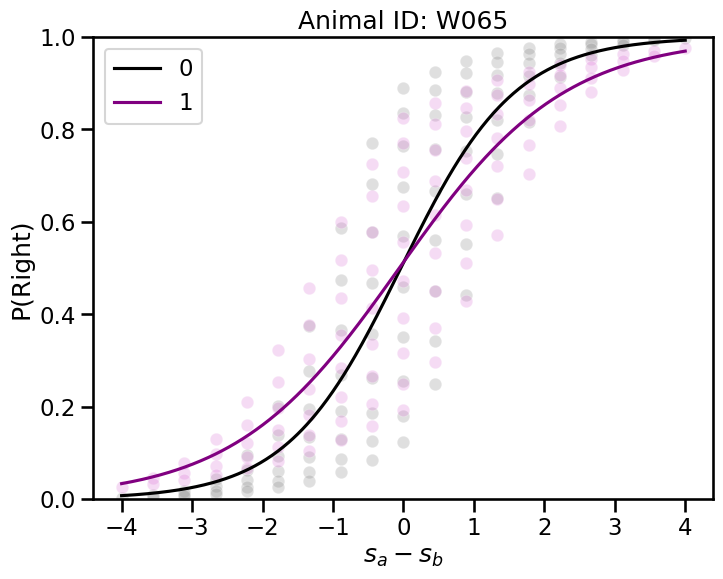

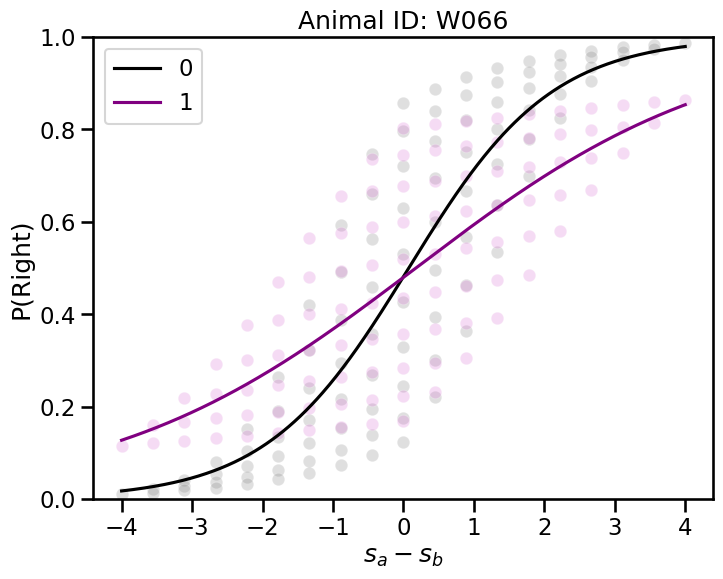

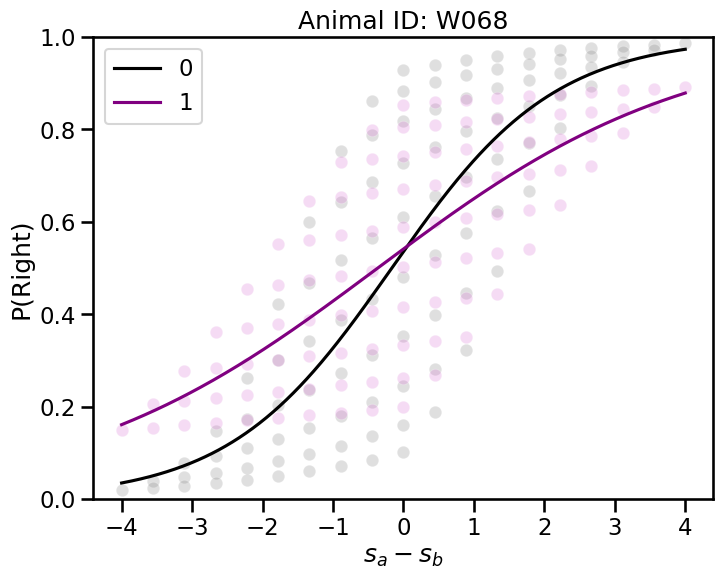

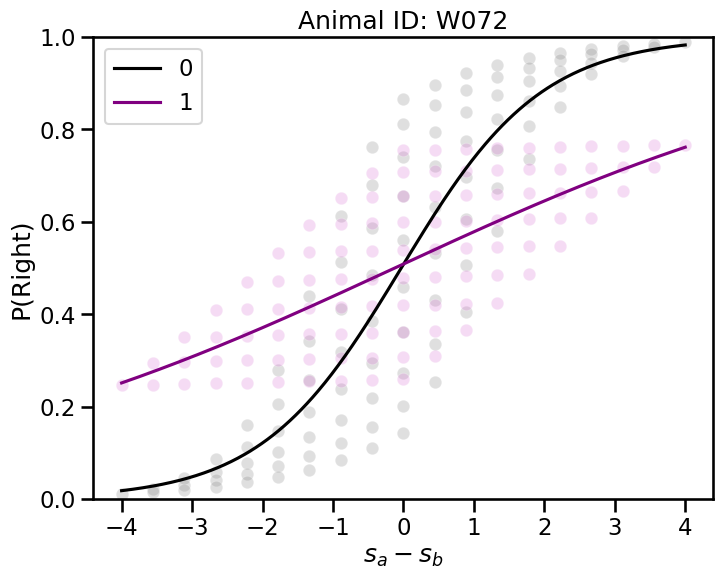

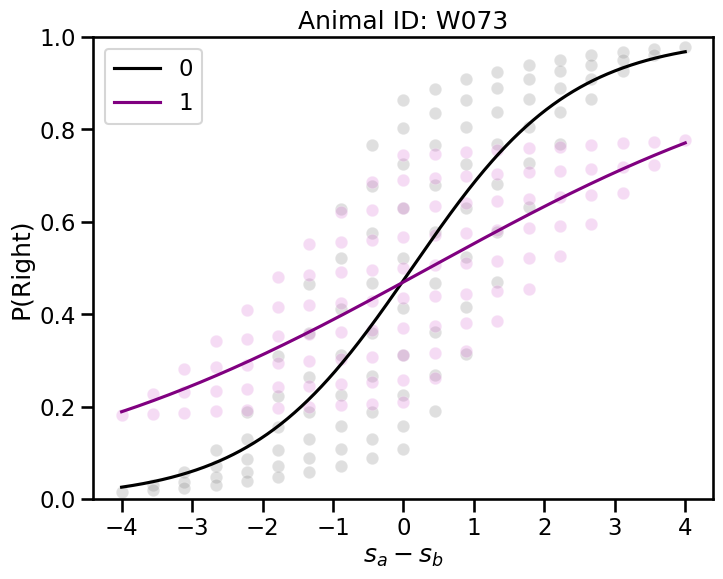

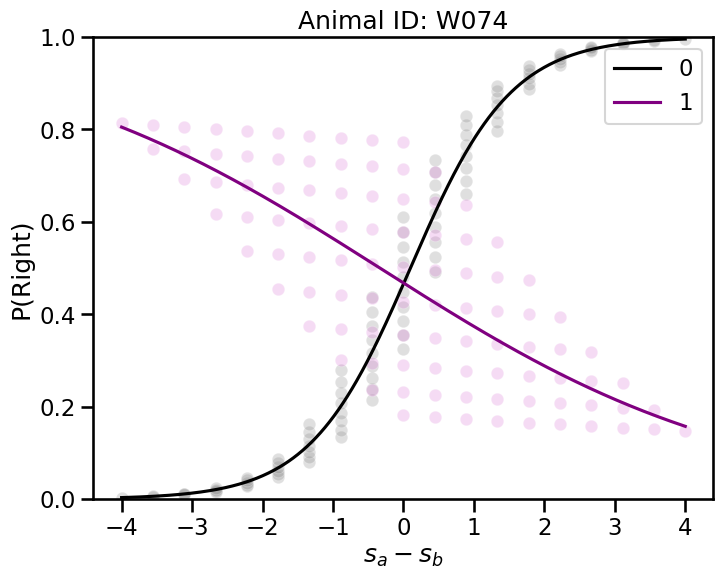

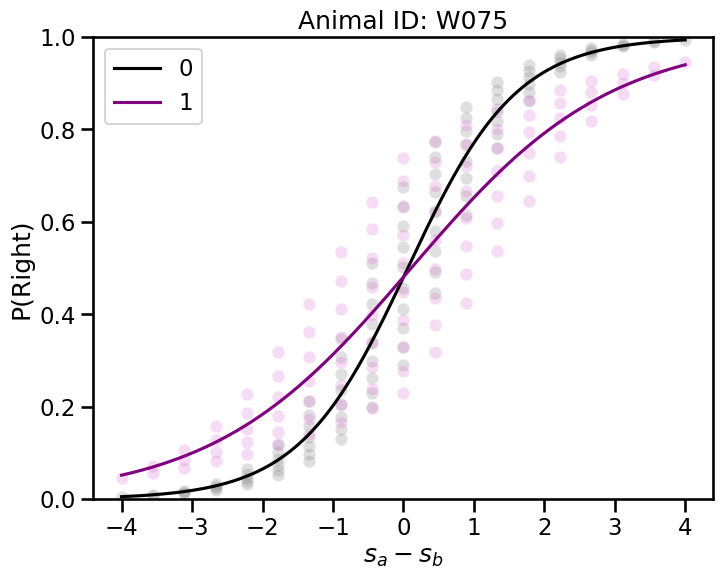

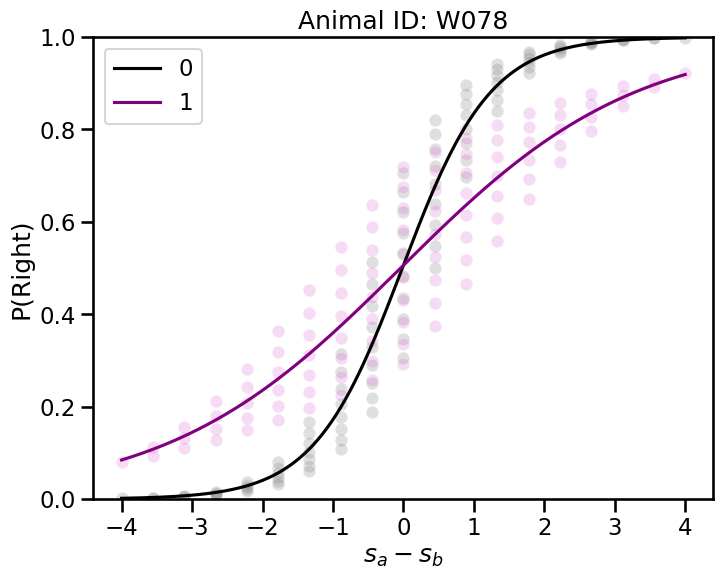

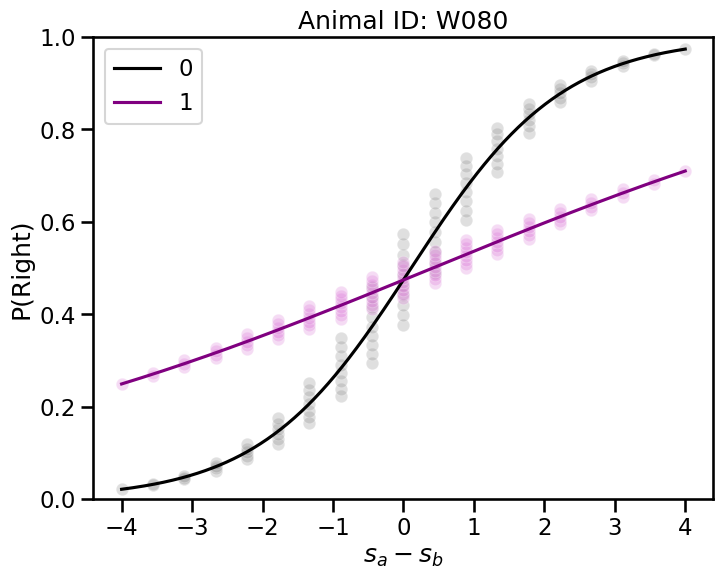

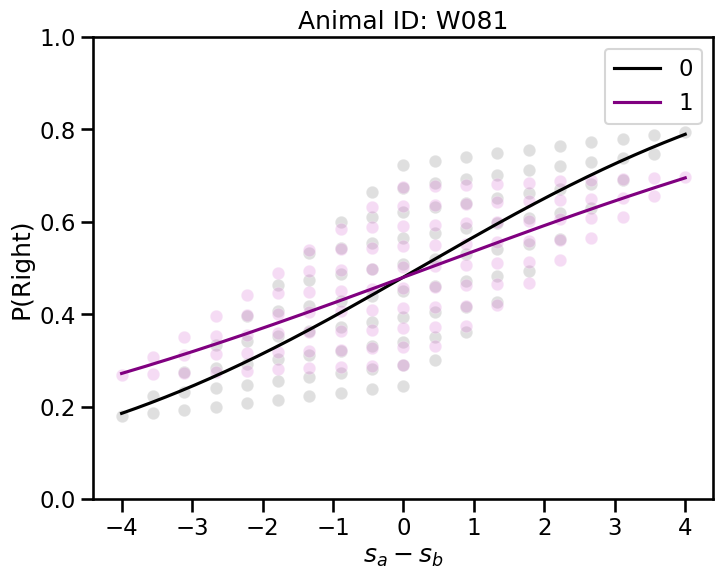

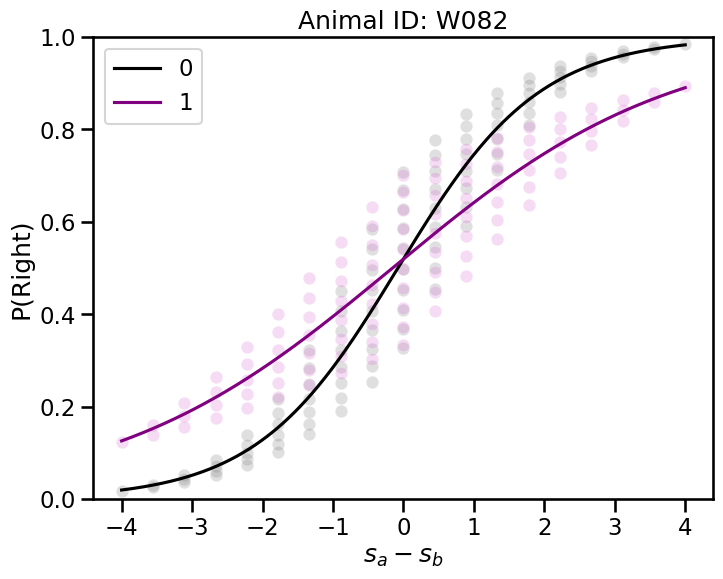

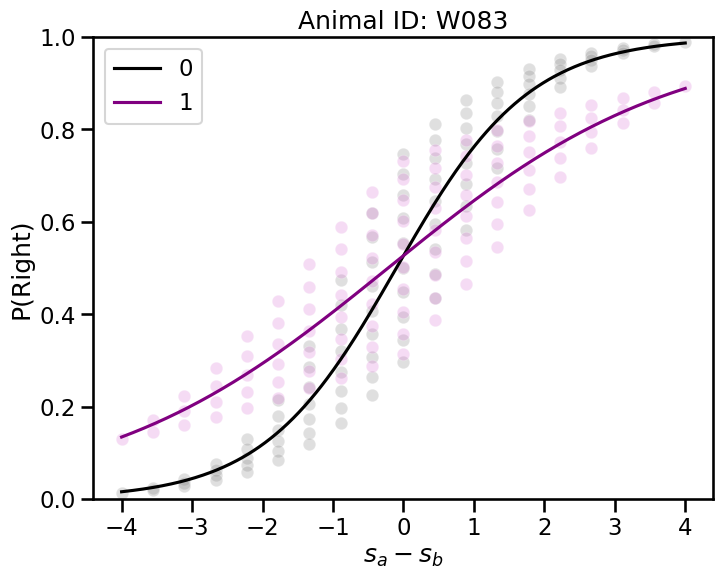

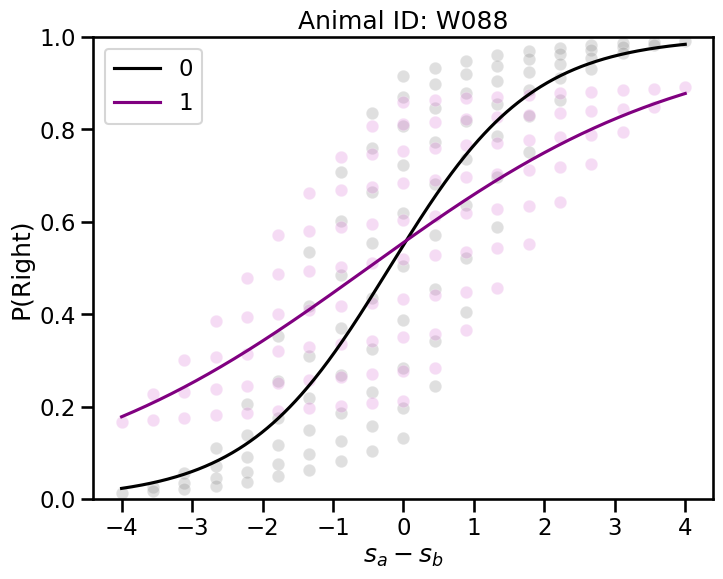

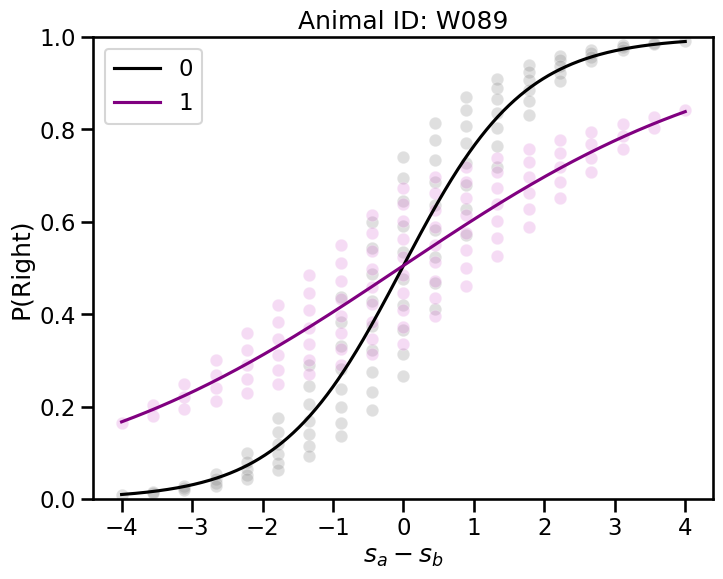

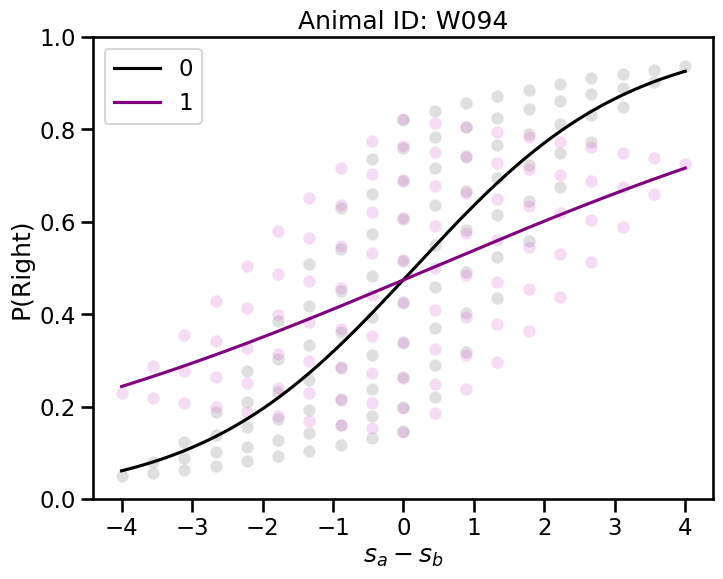

In [51]:
# List to collect fit results
fit_results = []
psych_results = []

# Loop over each unique animal

for animal_id in delta_weights_df["animal_id"].unique():
    sub_df = delta_weights_df.query(f"animal_id == '{animal_id}'")

    fig, ax = plt.subplots(figsize=(8, 6))

    for filter_val in [0, 1]:
        # Simulate the psychometric data
        deltax, ys = simulate_psych(sub_df, X_enhanced, filter_val)

        # Fit the psychometric function
        params, covariance = fit_psych(deltax, ys)

        # Collect the results
        fit_results.append(
            {
                "animal_id": animal_id,
                "filter": "on" if filter_val else "off",
                "alpha": params[0],
                "beta": params[1],
            }
        )

        # Plot the results
        sns.scatterplot(
            x=deltax,
            y=ys,
            ax=ax,
            alpha=0.25,
            color="orchid" if filter_val else "gray",
        )
        x_vals = np.linspace(deltax.min(), deltax.max(), 500)
        fitted_ys = sigmoid_for_curve_fit(x_vals, *params)

        psych_results.extend(
            {
                "animal_id": animal_id,
                "delta_stim": x_val,
                "p_right": y_val,
                "filter_val": filter_val,
            }
            for x_val, y_val in zip(x_vals, fitted_ys)
        )
        sns.lineplot(
            x=x_vals,
            y=fitted_ys,
            ax=ax,
            label=filter_val,
            color="purple" if filter_val else "black",
        )

    ax.set_title(f"Animal ID: {animal_id}")
    ax.set_xlabel("$s_a - s_b$")
    ax.set_ylabel("P(Right)")
    ax.set_ylim(0, 1)
    ax.legend()
    plt.show()

# Create a DataFrame from the collected fit results
fit_results_df = pd.DataFrame(fit_results)
psych_results_df = pd.DataFrame(psych_results)

# Optional: Save fit results to a file
# fit_results_df.to_csv('fit_results.csv', index=False)

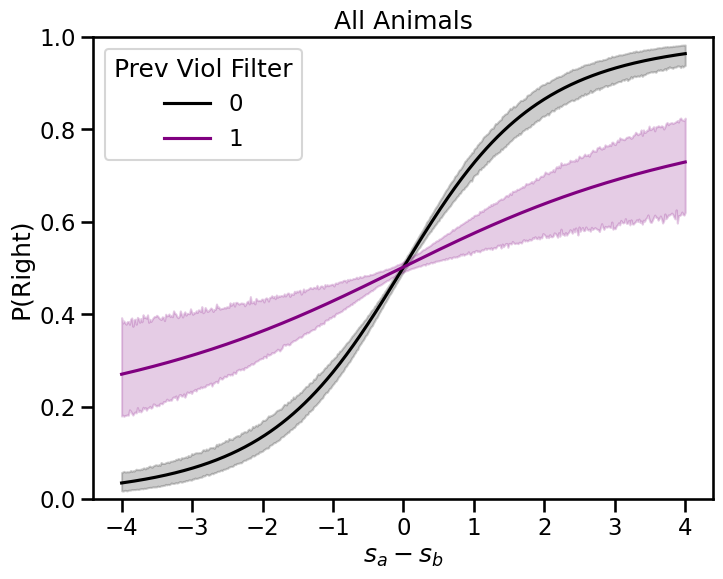

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(
    data=psych_results_df,
    x="delta_stim",
    y="p_right",
    ax=ax,
    hue="filter_val",
    hue_order=[0, 1],
    palette=["black", "purple"],
)

ax.set_title(f"All Animals")
ax.set_xlabel("$s_a - s_b$")
ax.set_ylabel("P(Right)")
ax.set_ylim(0, 1)
ax.legend(title="Prev Viol Filter", loc="upper left")
plt.show()

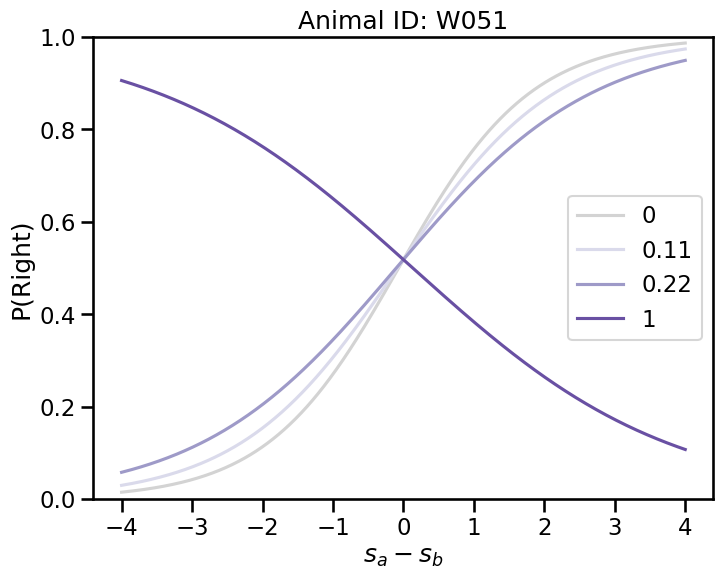

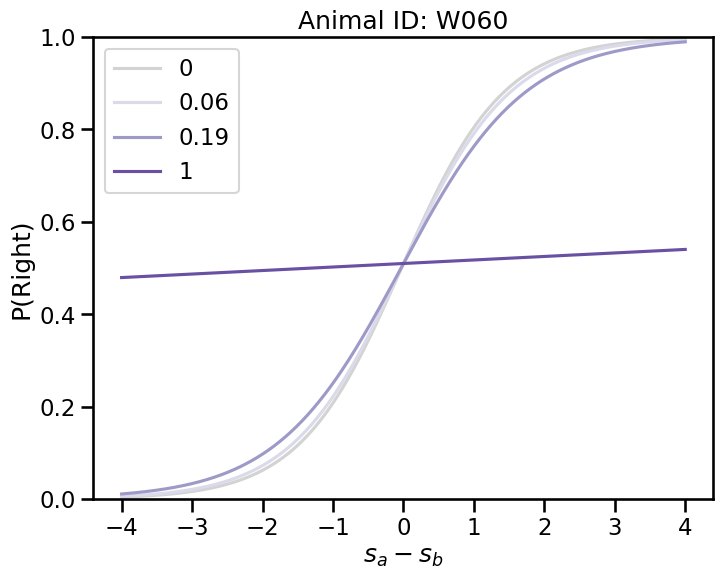

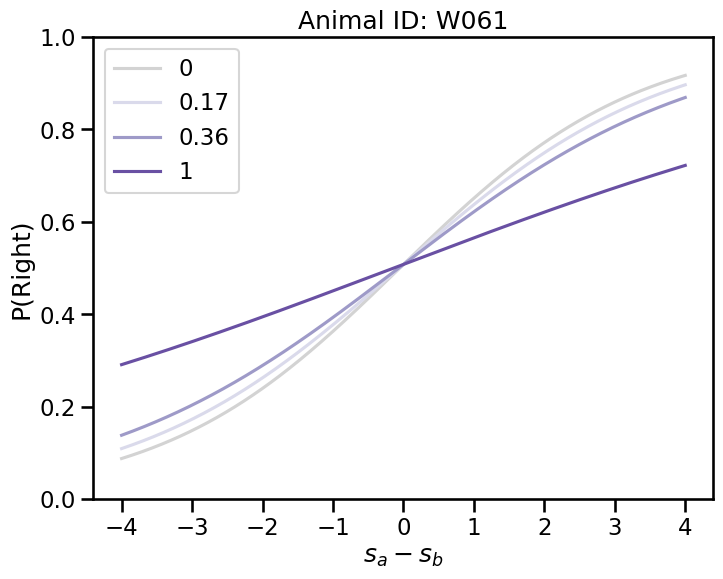

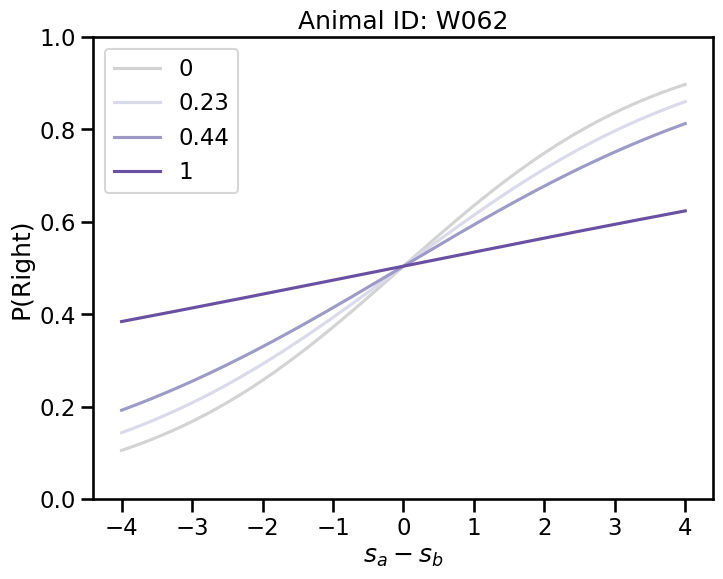

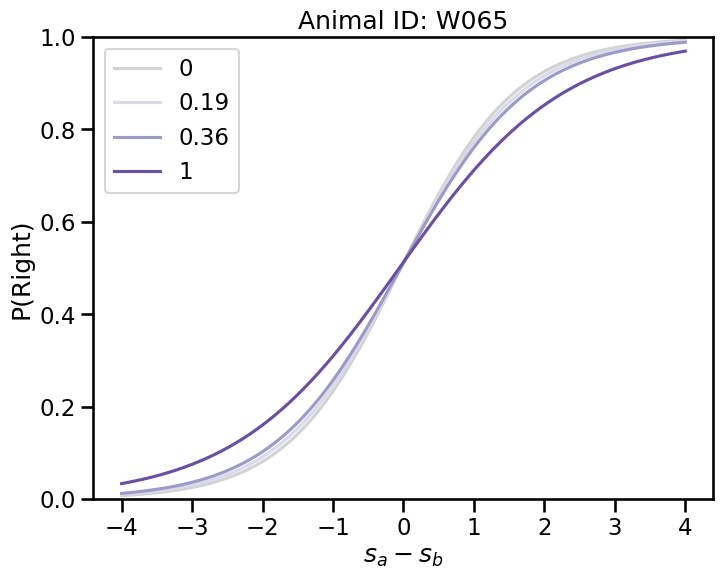

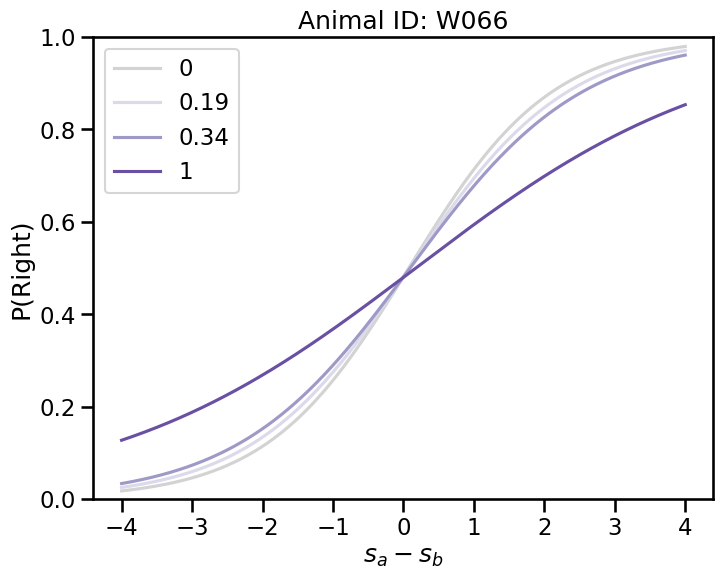

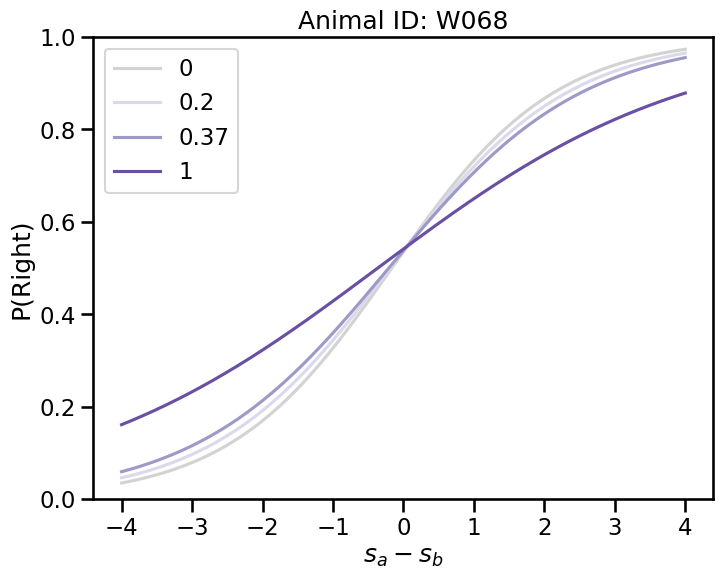

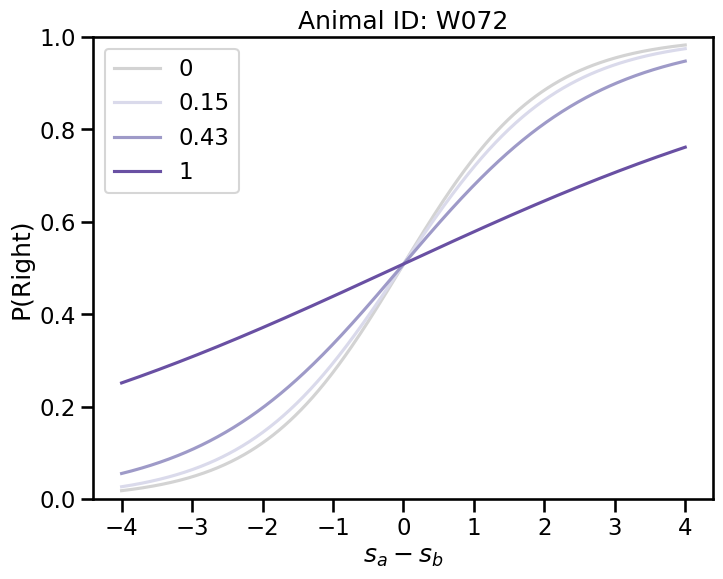

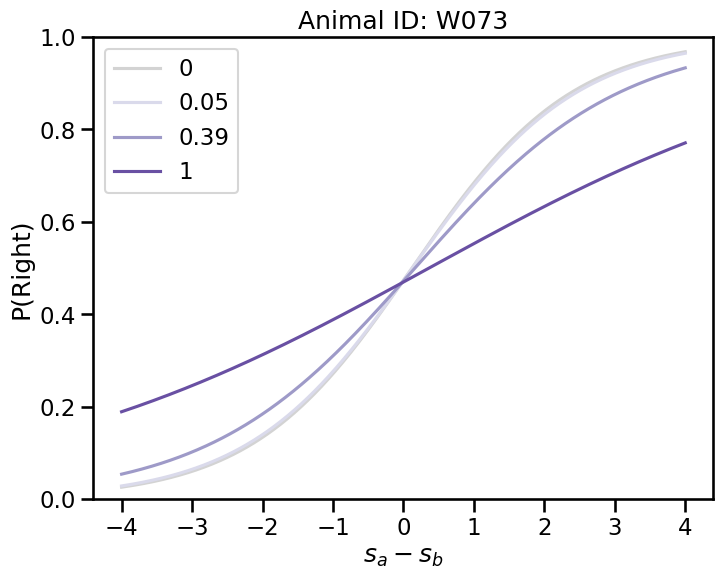

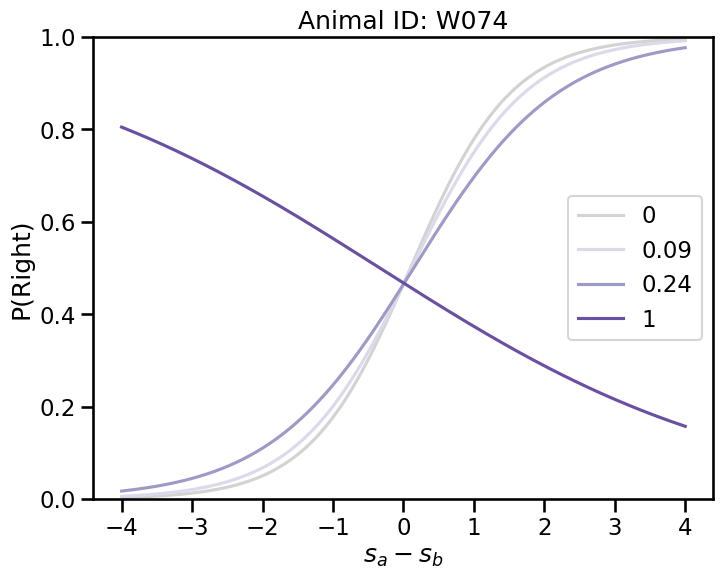

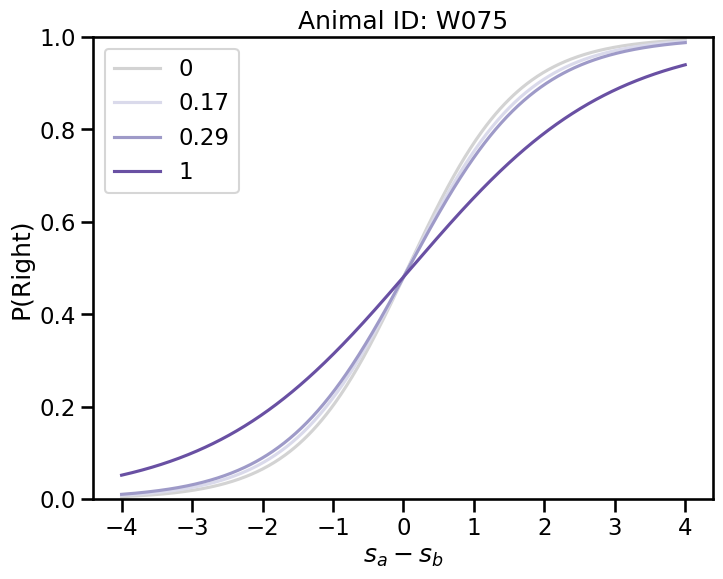

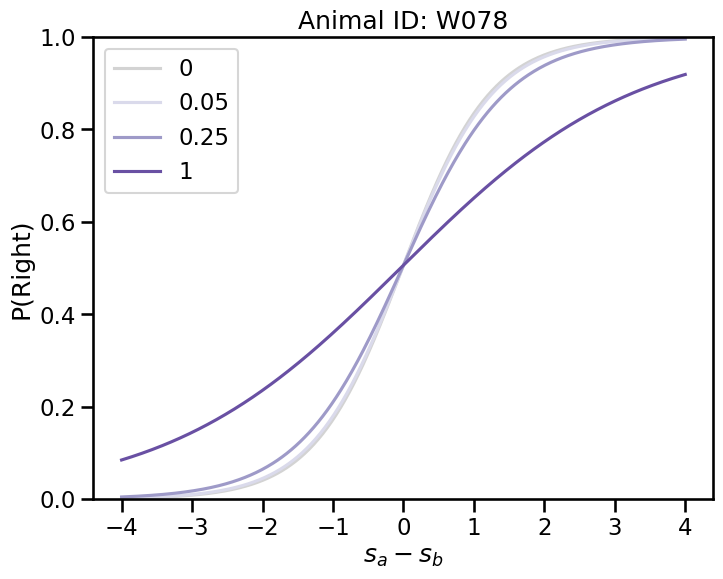

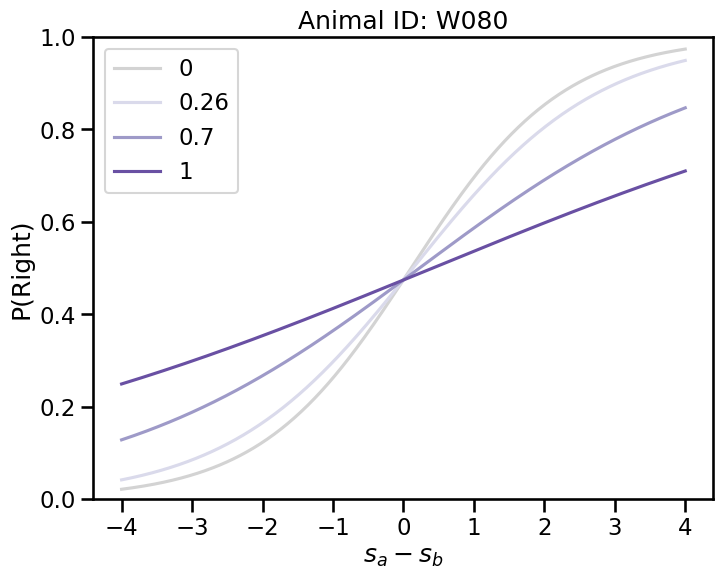

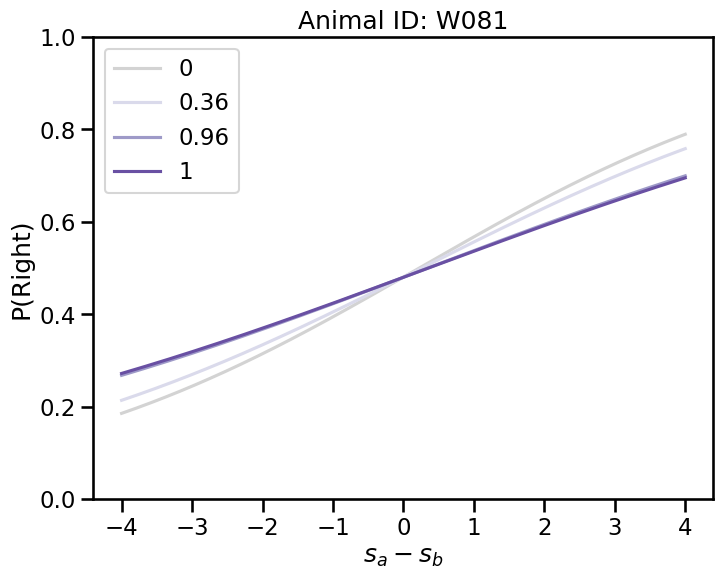

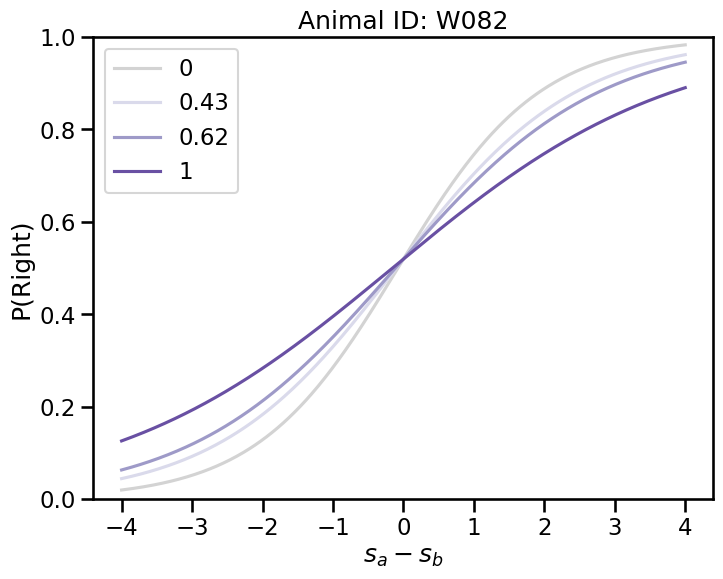

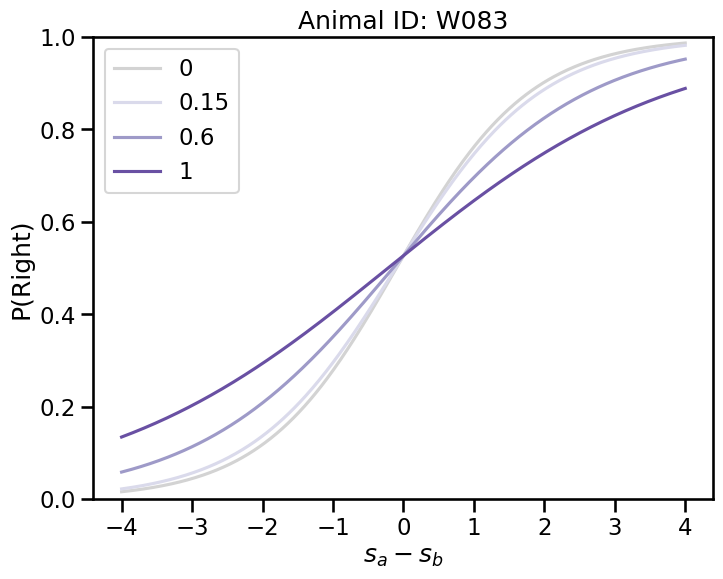

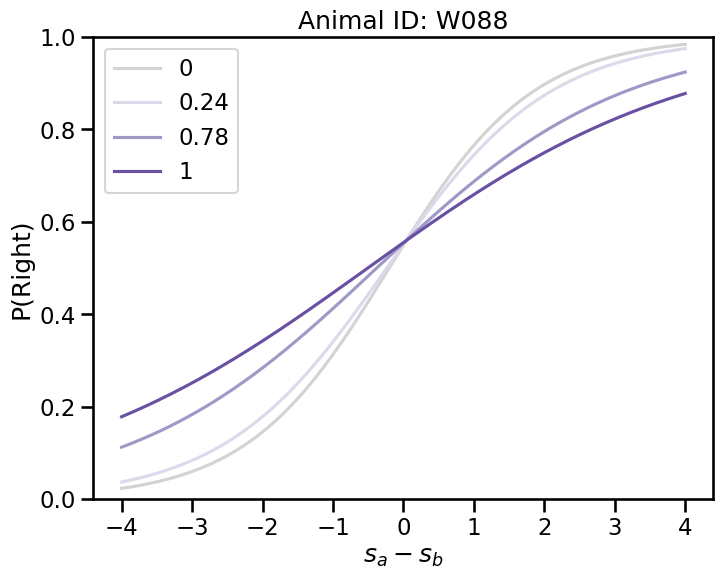

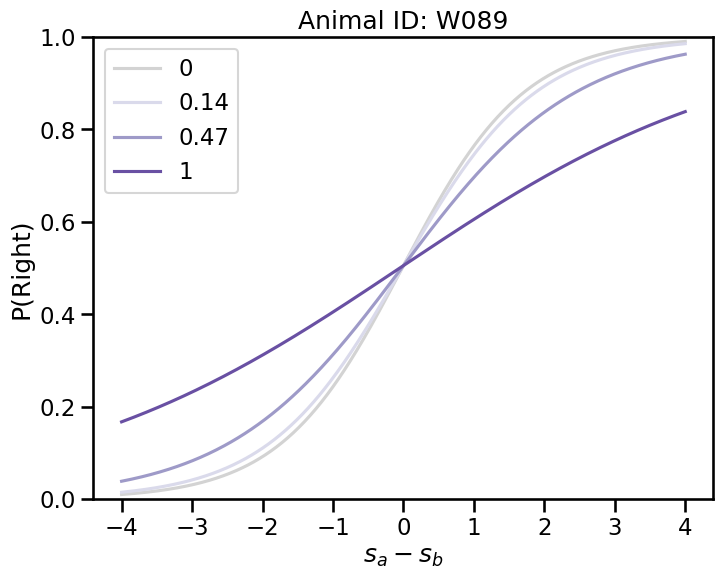

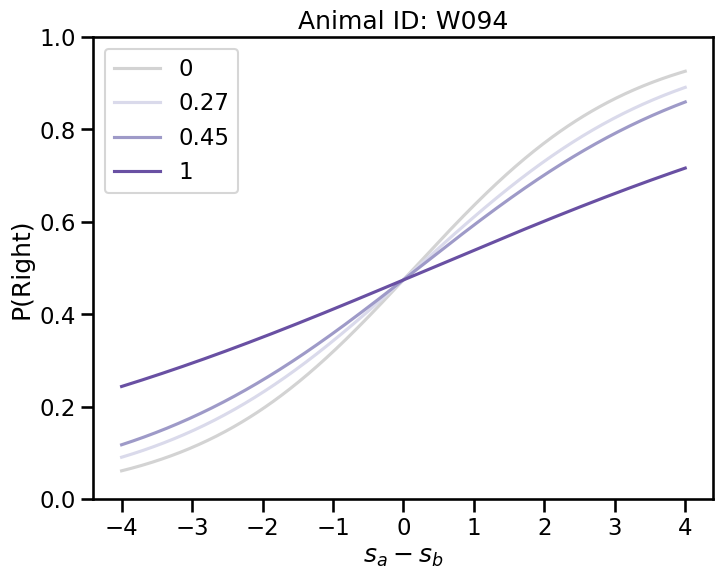

In [55]:
# List to collect fit results
full_fit_results = []
full_psych_results = []
summary_viol_df = pd.read_csv(results_path + "2023_12_10_summary_viol_df.csv")
psych_pallette = ["lightgray"] + [x for x in sns.color_palette("Purples", 3)]
filter_type = ["min (0)", "median", "75%", "max (1)"]
# Loop over each unique animal

for animal_id in delta_weights_df["animal_id"].unique():
    sub_df = delta_weights_df.query(f"animal_id == '{animal_id}'")

    meidan_filter_val = summary_viol_df.query("animal_id == @animal_id")[
        "median_prev_viol_exp"
    ].values[0]

    quartile_75_filter_val = summary_viol_df.query("animal_id == @animal_id")[
        "quartile_75_prev_viol_exp"
    ].values[0]

    fig, ax = plt.subplots(figsize=(8, 6))

    for idx, filter_val in enumerate([0, meidan_filter_val, quartile_75_filter_val, 1]):
        # Simulate the psychometric data
        deltax, ys = simulate_psych(sub_df, X_enhanced, filter_val)

        # Fit the psychometric function
        params, covariance = fit_psych(deltax, ys)

        # Collect the results
        full_fit_results.append(
            {
                "animal_id": animal_id,
                "filter": filter_val,
                "alpha": params[0],
                "beta": params[1],
            }
        )

        x_vals = np.linspace(deltax.min(), deltax.max(), 500)
        fitted_ys = sigmoid_for_curve_fit(x_vals, *params)

        full_psych_results.extend(
            {
                "animal_id": animal_id,
                "delta_stim": x_val,
                "p_right": y_val,
                "filter_val": filter_val,
                "filter_type": filter_type[idx],
            }
            for x_val, y_val in zip(x_vals, fitted_ys)
        )
        sns.lineplot(
            x=x_vals,
            y=fitted_ys,
            ax=ax,
            label=np.round(filter_val, 2),
            color=psych_pallette[idx],
        )

    ax.set_title(f"Animal ID: {animal_id}")
    ax.set_xlabel("$s_a - s_b$")
    ax.set_ylabel("P(Right)")
    ax.set_ylim(0, 1)
    ax.legend()
    plt.show()

# Create a DataFrame from the collected fit results
full_fit_results_df = pd.DataFrame(full_fit_results)
full_psych_results_df = pd.DataFrame(full_psych_results)

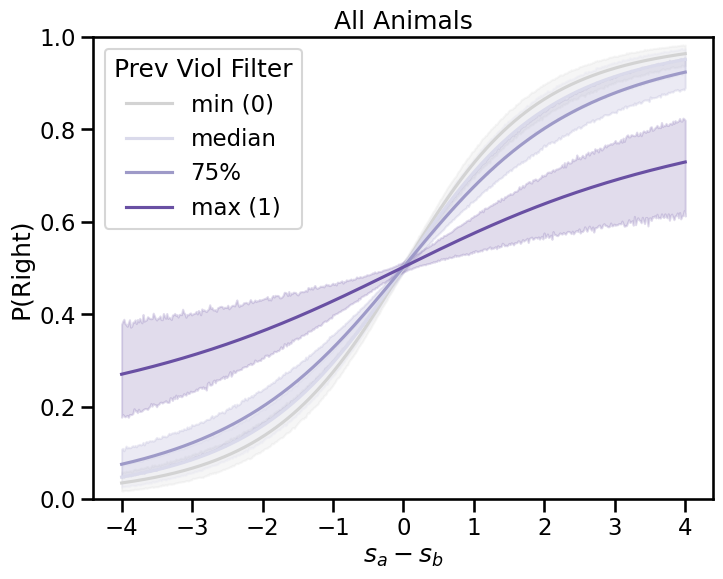

In [56]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(
    data=full_psych_results_df,
    x="delta_stim",
    y="p_right",
    ax=ax,
    hue="filter_type",
    hue_order=filter_type,
    palette=psych_pallette,
)

ax.set_title(f"All Animals")
ax.set_xlabel("$s_a - s_b$")
ax.set_ylabel("P(Right)")
ax.set_ylim(0, 1)
ax.legend(title="Prev Viol Filter", loc="upper left")
plt.show()

**TODO**- would be interesting to see how psychometric varies by tau for each animal. This would require a fixed filter value.  